In [24]:
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
import random as rd
import matplotlib.pyplot as plt
import seaborn as snb
from sklearn import preprocessing


In [2]:
def evaluate_model(model, X_train, y_train, cv, debug = False):
    list_specificity = []
    list_sensibility = []
    scores = cross_validate(model, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
    estimators = scores['estimator']
    print(f"Accuracy: {np.mean(scores['test_score'])}\n\n")
    
    if (debug):
        for i, (train_index, test_index) in enumerate(cv.split(X_train)):
    
            X_pred = X_train[test_index]
            y_ground = y_train[test_index]
            y_pred = estimators[0].predict(X_pred)
            tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
            sensibility = tp / (tp + fn)
            specificity = tn / (tn + fp)
            list_sensibility.append(sensibility)
            list_specificity.append(specificity)
    
            print(f"Fold {i}")
            print(f'Number of samples: {len(X_pred)}')
            print(f"Mean Specificity= {specificity}")
            print(f"Mean Sensibility= {sensibility}\n\n")
  
            ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
            plt.grid(False)
            plt.show()
    
        print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    return estimators

In [37]:
def show_roc_curve(classifier, y_true, X):
    y_pred = classifier.predict(X)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc = roc_auc_score(y_true, y_pred)
    RocCurveDisplay.from_predictions(y_true, y_pred, pos_label=1)
    return (fpr, tpr, thresholds, auc)

In [38]:
def evaluate_kfold(list_of_estimators, X_total, y_total):
    # Verificando a media com todos os elementos e classificadores
    list_sensibility = []
    list_specificity = []
    list_false_positive_rate = []
    X_pred = X_total
    y_truth = y_total
    
    for i, estimator in enumerate(list_of_estimators):
  
        y_pred = estimator.predict(X_pred)
        tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
        sensibility = tp / (tp + fn)
        specificity = tn / (tn + fp)
        sensibility = tp / (tp + fn)
        false_positive_rate = 1 - specificity
        print(f'Number of samples: {len(X_pred)}')
        print(f"Specificity= {specificity}")
        print(f"Sensibility= {sensibility}\n\n")
        print(f'False Positive rate: {false_positive_rate}')
        list_sensibility.append(sensibility)
        list_specificity.append(specificity)
        list_false_positive_rate.append(false_positive_rate)
        
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
        show_roc_curve(estimator, y_truth, X_total)
        plt.grid(False)
        plt.show()

    print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
    print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")


In [4]:
# Seed
seed = 123456

In [7]:
df = pd.read_csv('../data/complete_dataset.csv', index_col=0)

In [8]:
df.head()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,111.206245,-128.070497,582.026580,239.276743,0.205634,84.763748,-89.000926,1
1,117.477703,-132.831311,554.636573,250.309014,0.199645,88.426733,-92.060480,1
2,111.984444,-133.417261,636.900253,245.401704,0.193656,87.221721,-93.731053,1
3,114.831800,-148.762000,497.157678,263.593800,0.187666,96.151949,-108.130415,1
4,100.741600,-122.019000,609.328195,222.760600,0.183673,83.015207,-90.556571,1


In [9]:
df.tail()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
50,93.579555,-142.099047,703.929038,235.678601,0.192003,77.378071,-99.576142,0
51,0.000000,-129.023850,629.446398,0.000000,0.000000,65.455168,-90.572485,0
52,107.623529,-130.686378,546.450781,238.309908,0.188003,82.729708,-88.611173,0
53,85.166931,-104.910982,686.594488,190.077913,0.188003,67.804083,-74.661710,0
54,85.041928,-109.342301,665.782497,194.384229,0.192003,64.283984,-73.564895,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   corrente_anodica                55 non-null     float64
 1   corrente_catodica               55 non-null     float64
 2   carga                           55 non-null     float64
 3   diff_corrente_anodica_catodica  55 non-null     float64
 4   diff_pot_anodico_catodico       55 non-null     float64
 5   pico_derivada_anodica           55 non-null     float64
 6   pico_derivada_catodica          55 non-null     float64
 7   target                          55 non-null     int64  
dtypes: float64(7), int64(1)
memory usage: 3.9 KB


In [11]:
df.head()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,111.206245,-128.070497,582.026580,239.276743,0.205634,84.763748,-89.000926,1
1,117.477703,-132.831311,554.636573,250.309014,0.199645,88.426733,-92.060480,1
2,111.984444,-133.417261,636.900253,245.401704,0.193656,87.221721,-93.731053,1
3,114.831800,-148.762000,497.157678,263.593800,0.187666,96.151949,-108.130415,1
4,100.741600,-122.019000,609.328195,222.760600,0.183673,83.015207,-90.556571,1


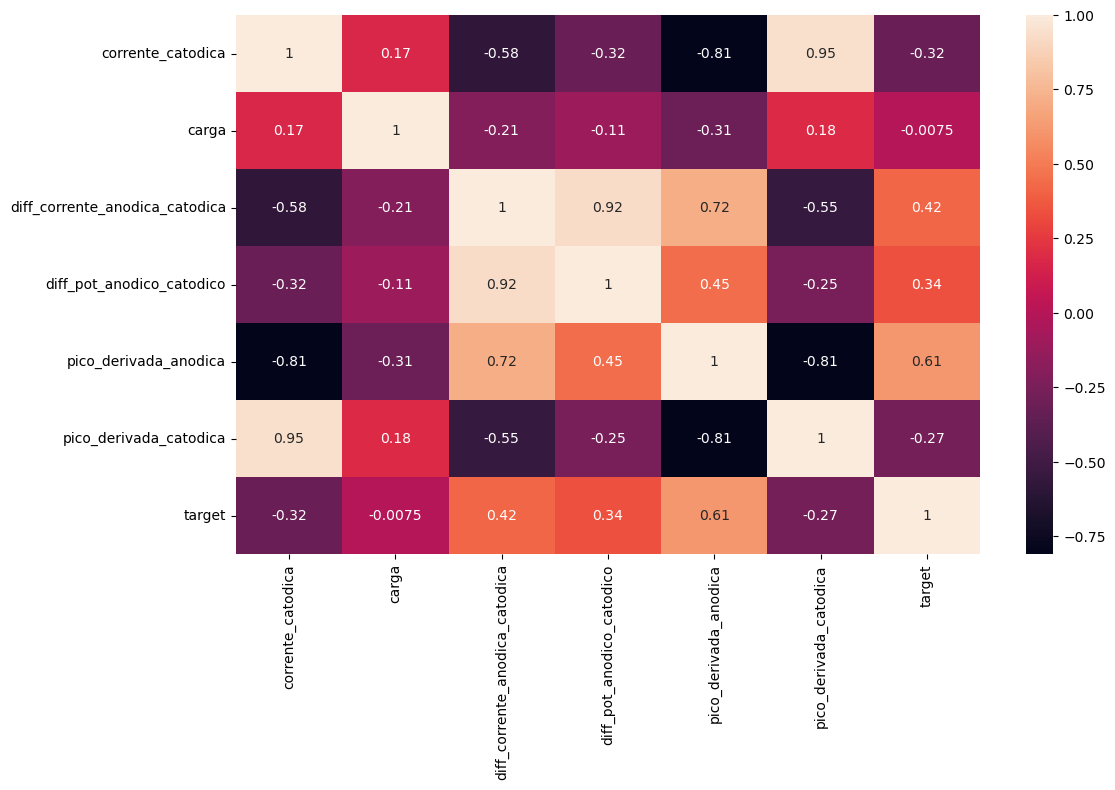

In [14]:
fig, ax = plt.subplots(figsize=(12,7))
ax = snb.heatmap(df.iloc[:,1:].corr(), annot=True)
plt.show()

In [34]:
# Preparando os dados
X = df.iloc[:,:-1]
#X.drop(['carga'], axis=1)
y = df['target']

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X.values)

cv = KFold(n_splits = len(X), random_state=seed, shuffle=True)
#Create a model for logistic regression
model = LogisticRegression(max_iter=1000, solver='liblinear')
scores = cross_validate(model, X_train, y.values, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
print("Acurracy %.3f", np.mean(np.mean(scores['test_score'])))

Acurracy %.3f 0.9090909090909091


Estimator 0


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




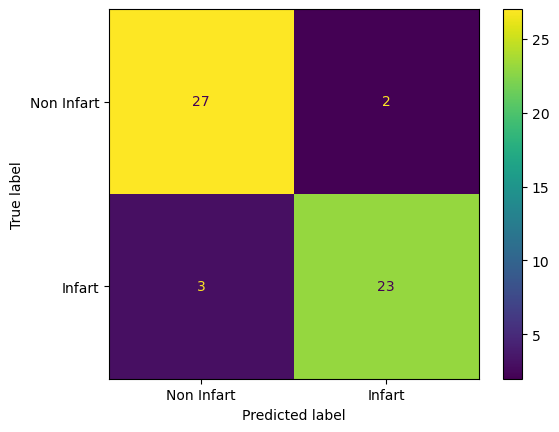

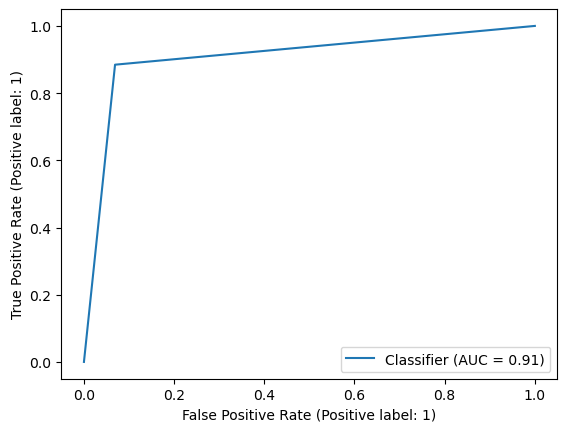

Estimator 1


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




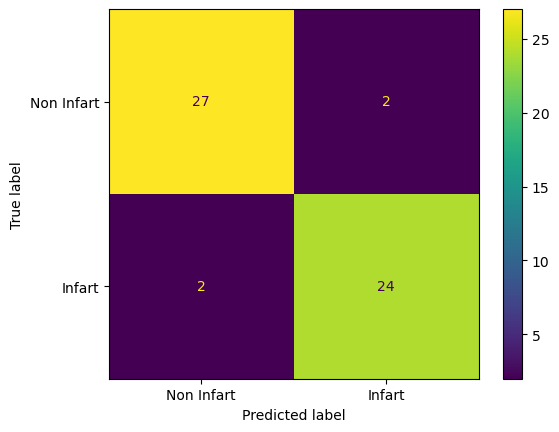

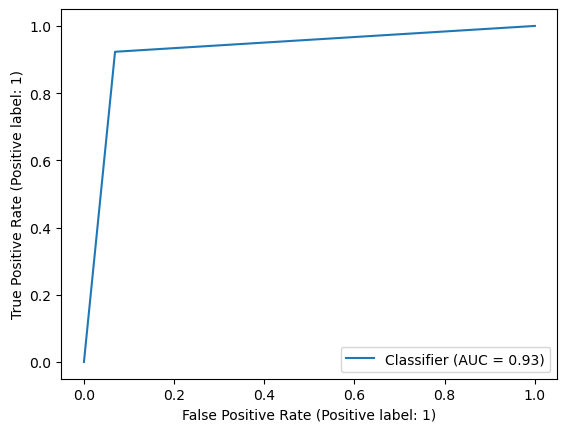

Estimator 2


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




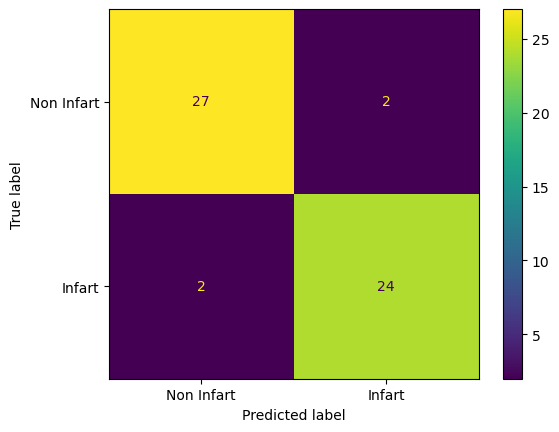

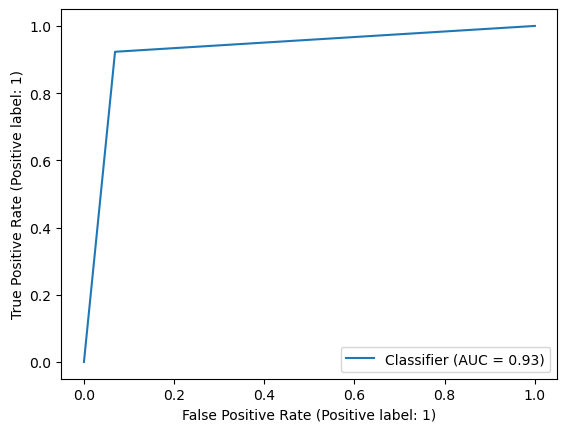

Estimator 3


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




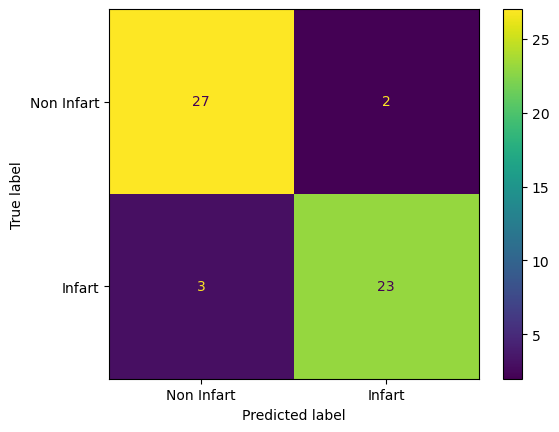

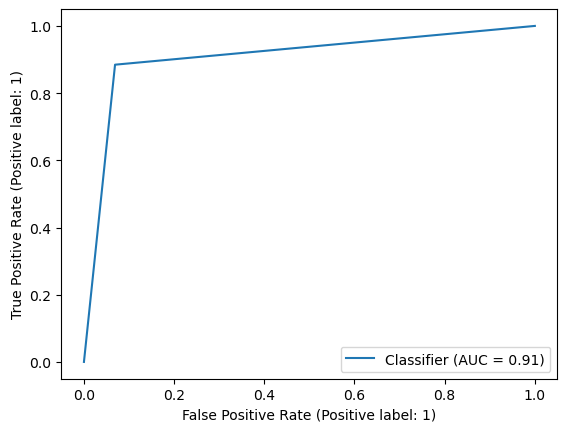

Estimator 4


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




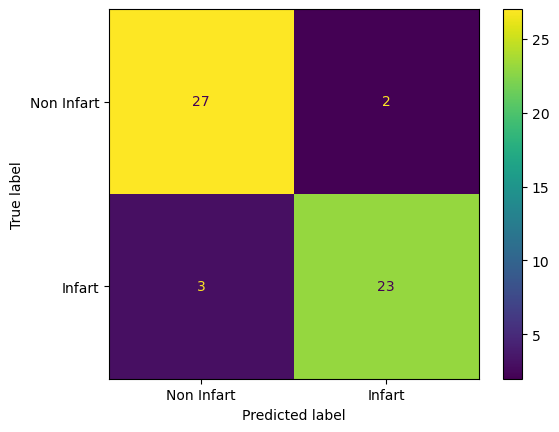

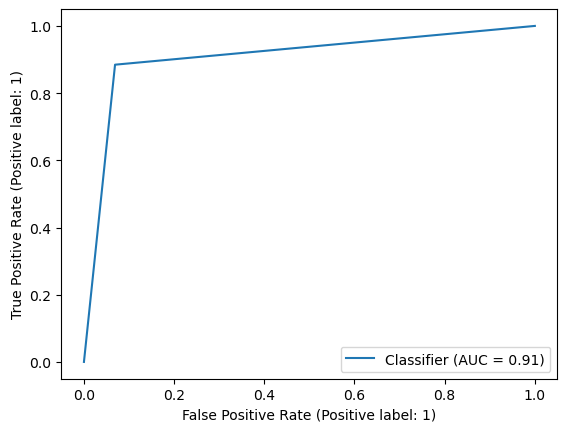

Estimator 5


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




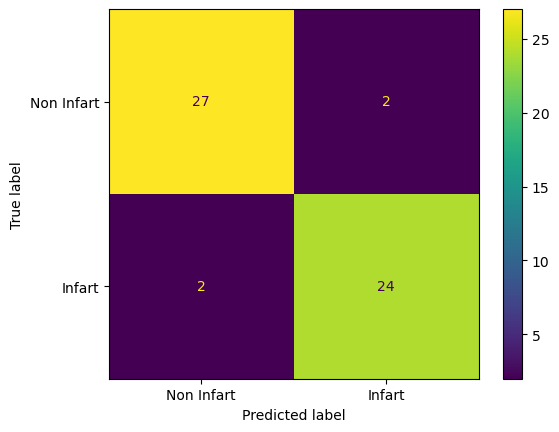

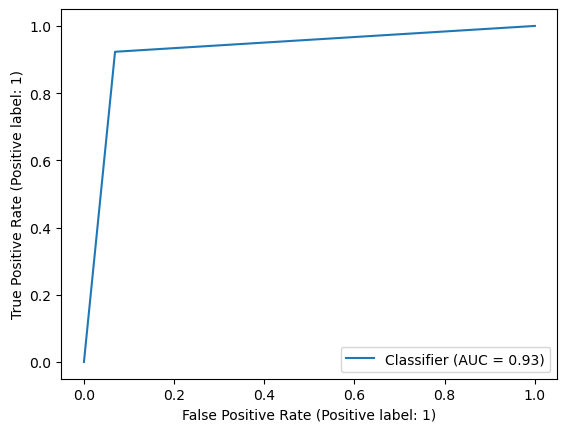

Estimator 6


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




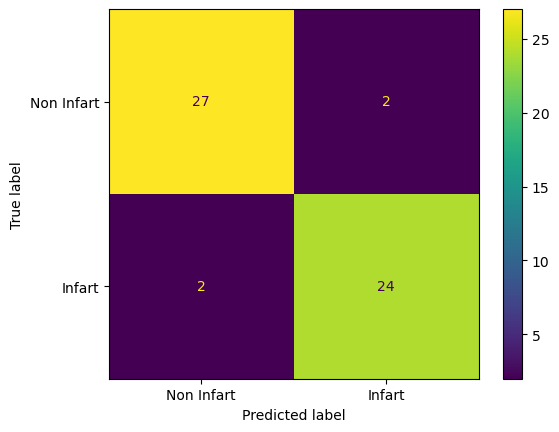

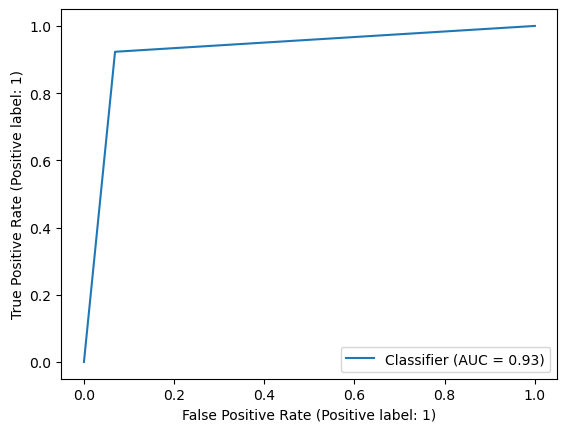

Estimator 7


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




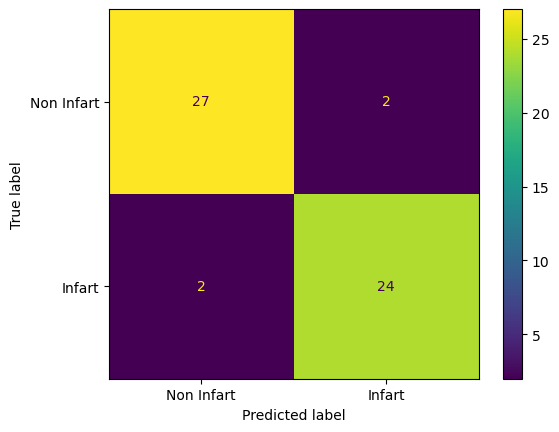

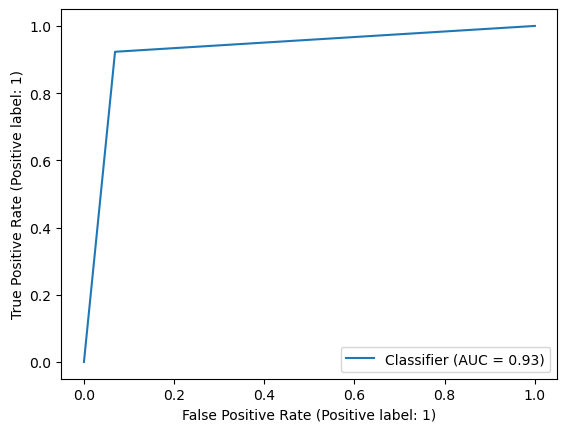

Estimator 8


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




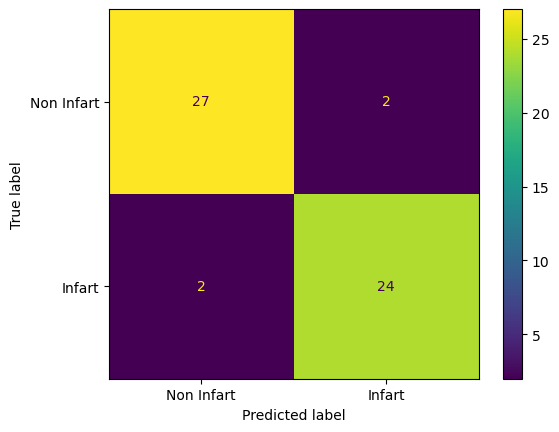

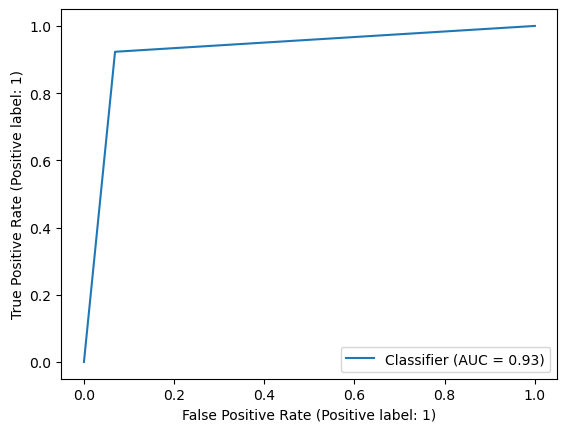

Estimator 9


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




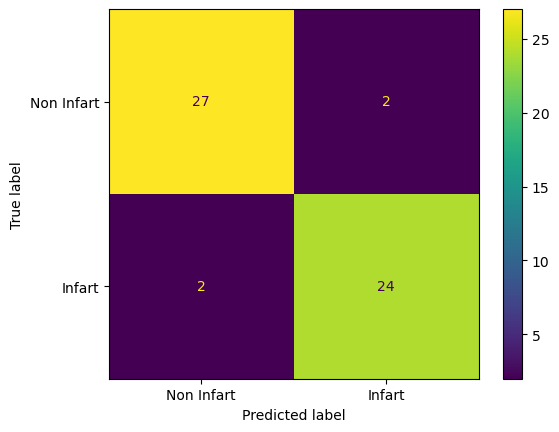

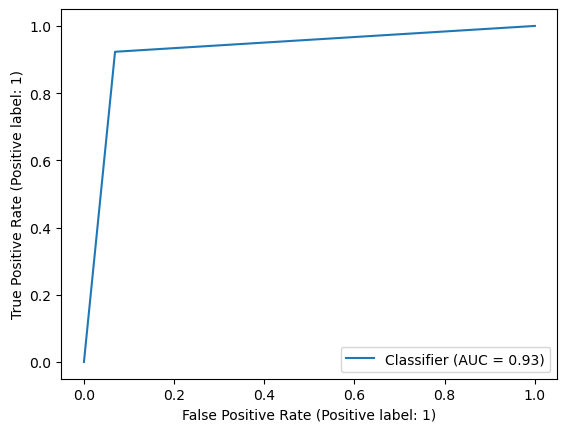

Estimator 10


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




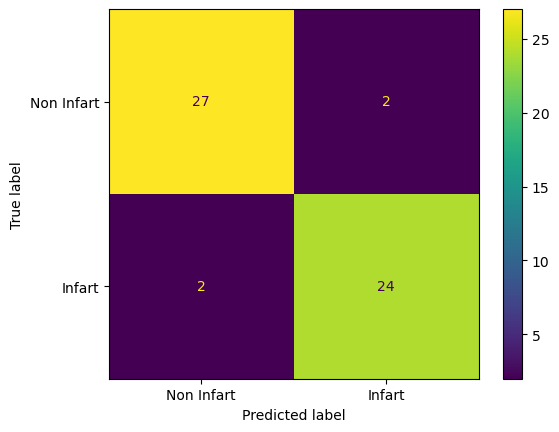

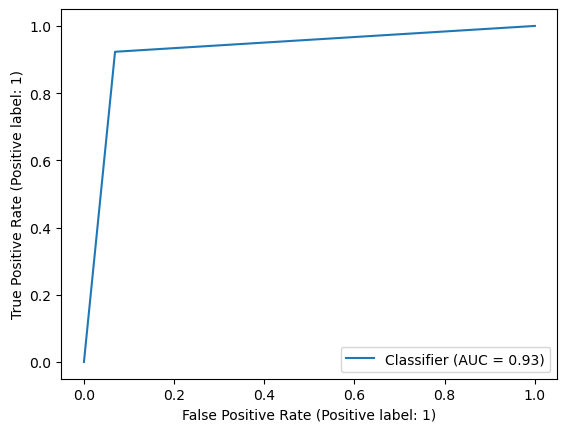

Estimator 11


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




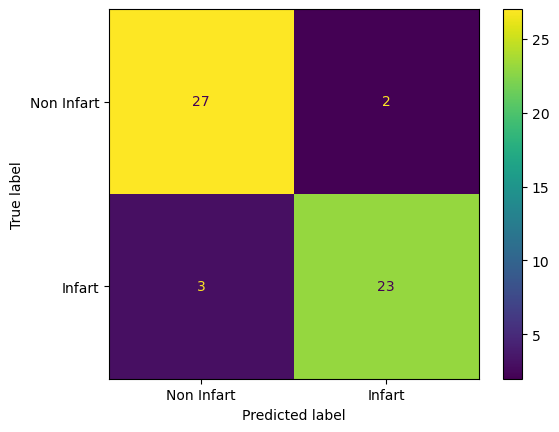

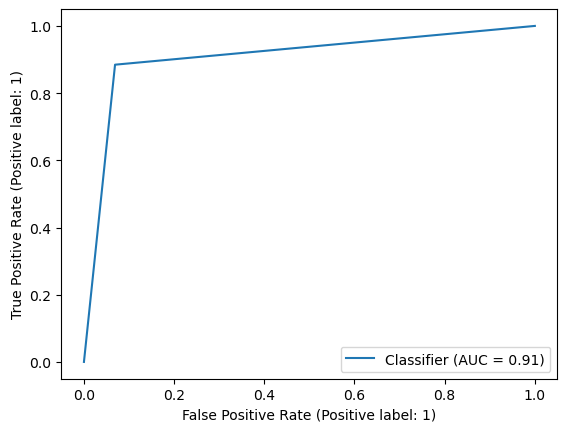

Estimator 12


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




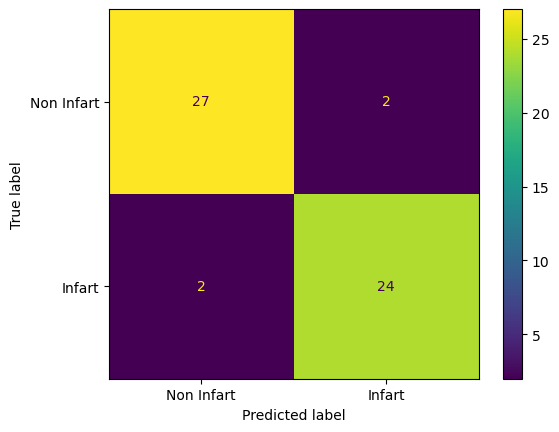

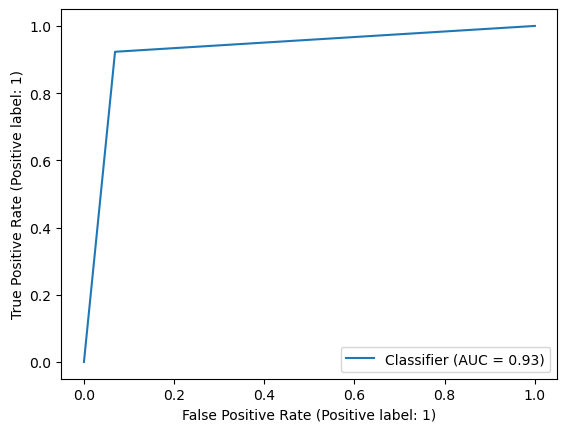

Estimator 13


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




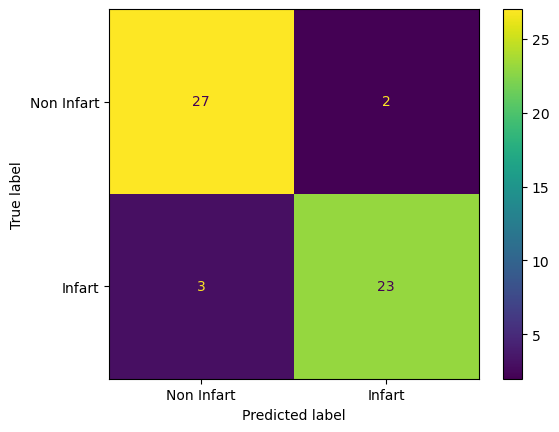

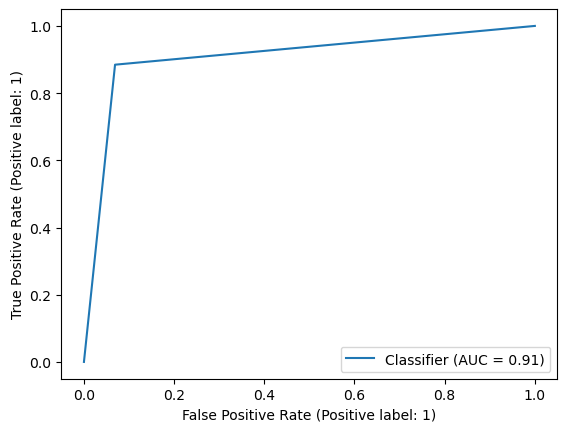

Estimator 14


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




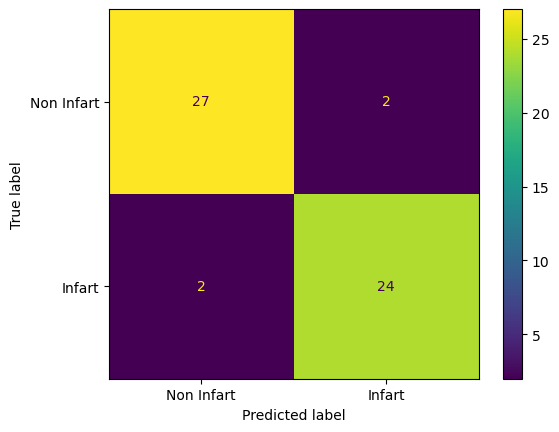

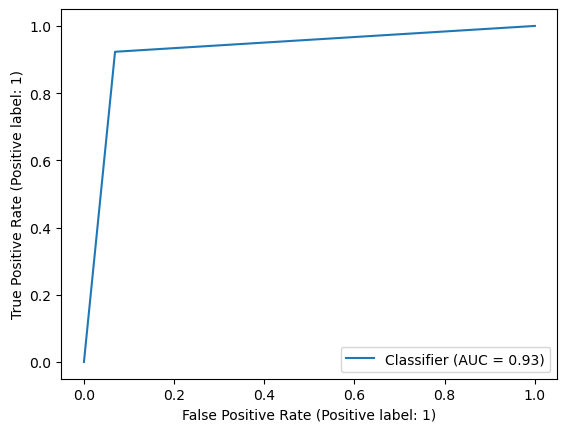

Estimator 15


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




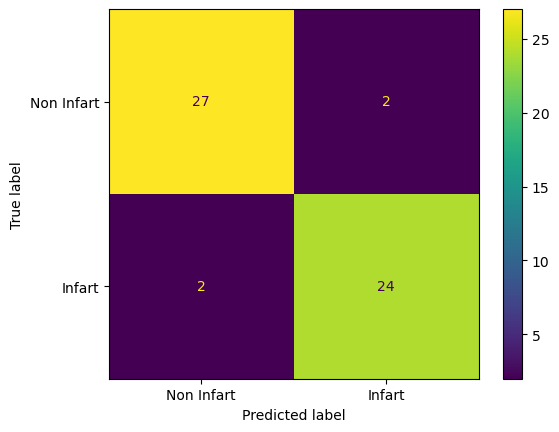

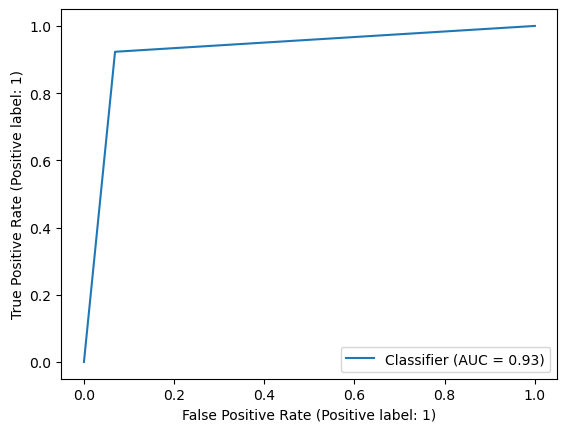

Estimator 16


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




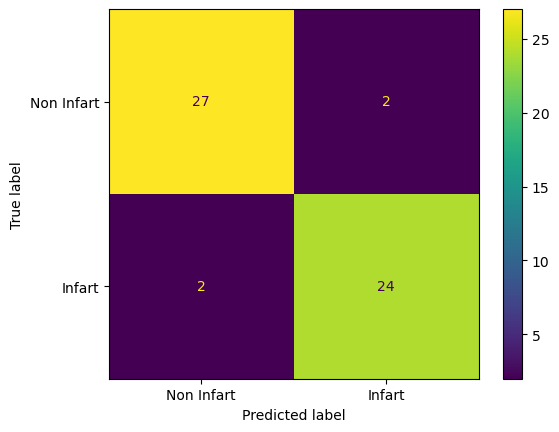

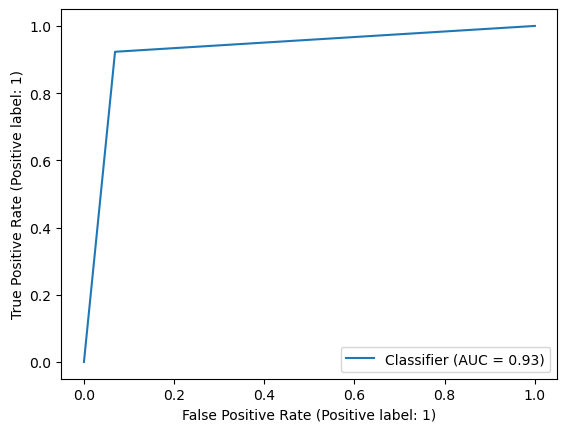

Estimator 17


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




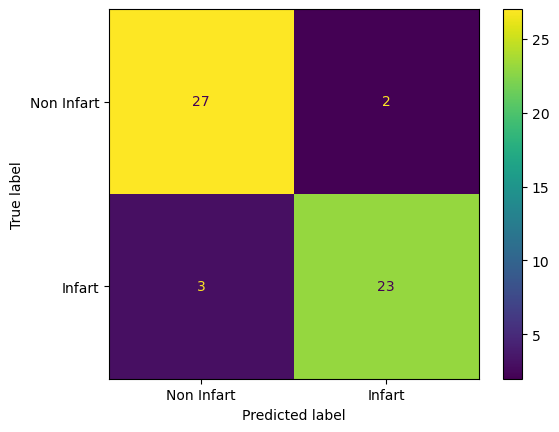

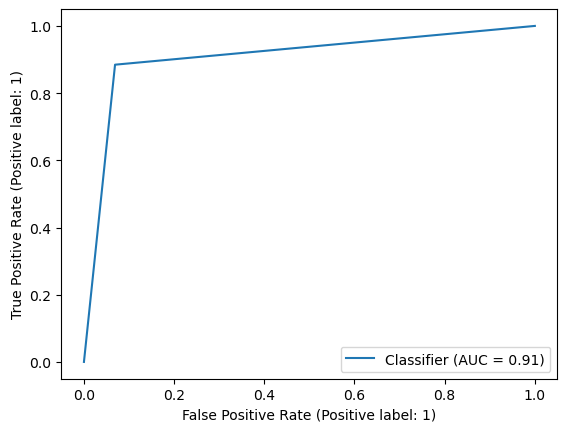

Estimator 18


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




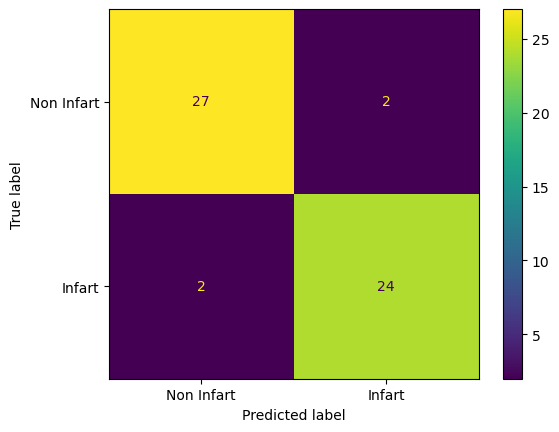

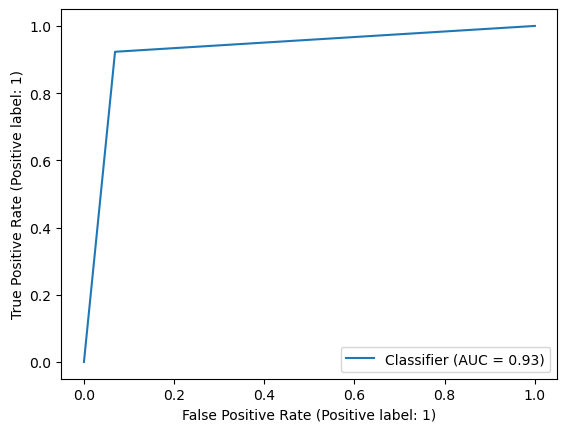

Estimator 19


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




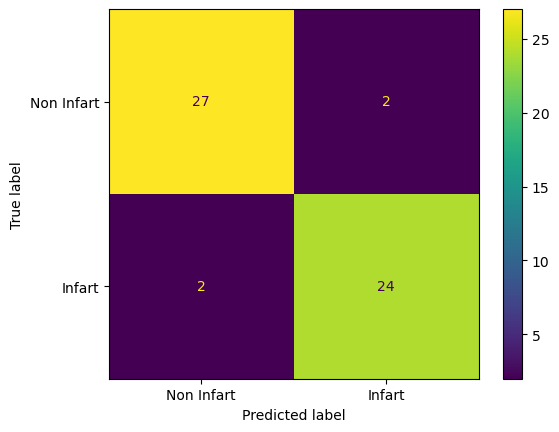

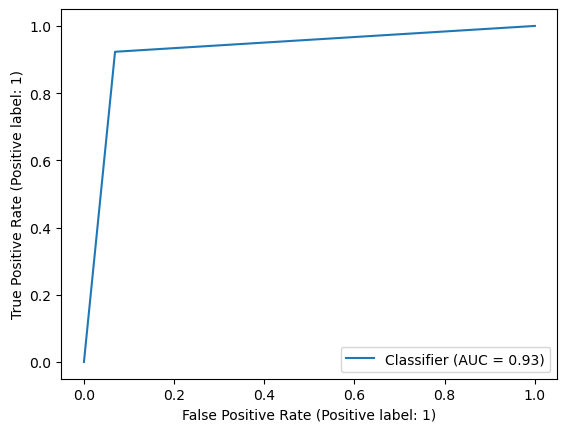

Estimator 20


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




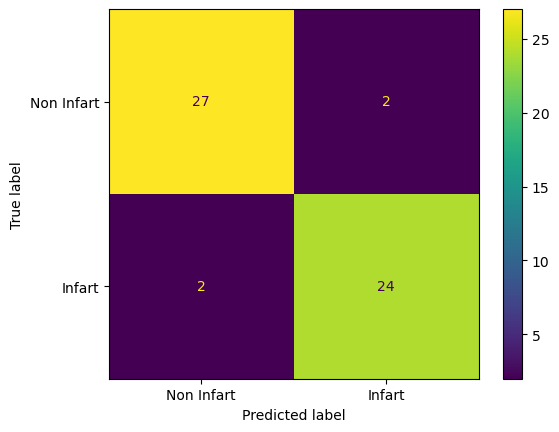

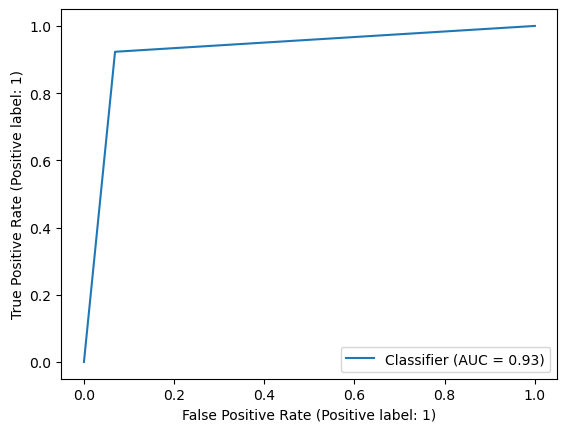

Estimator 21


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




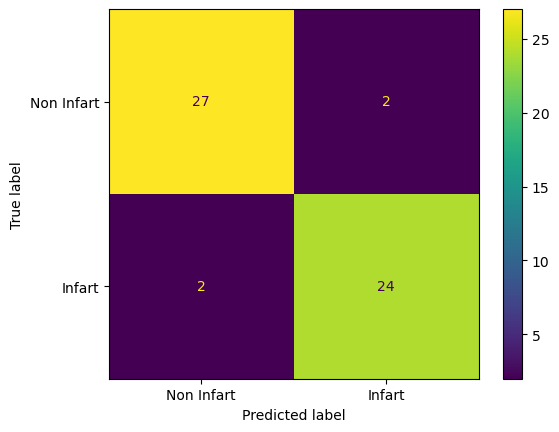

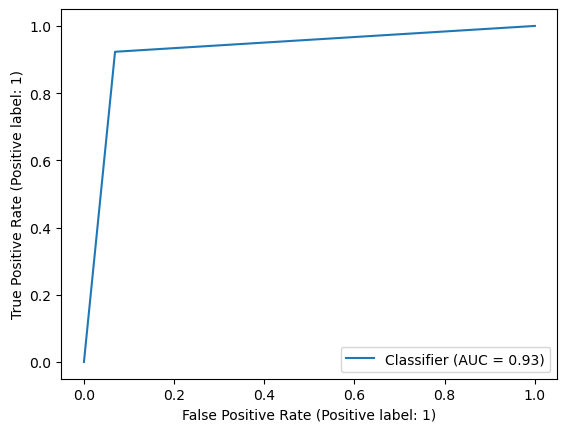

Estimator 22


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




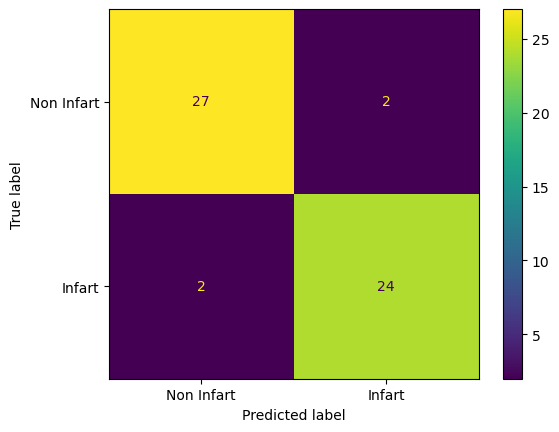

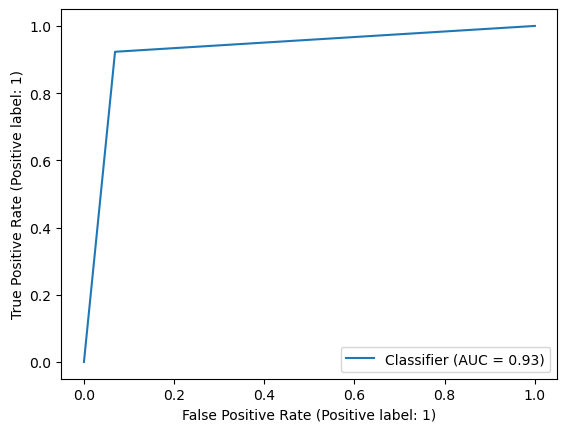

Estimator 23


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




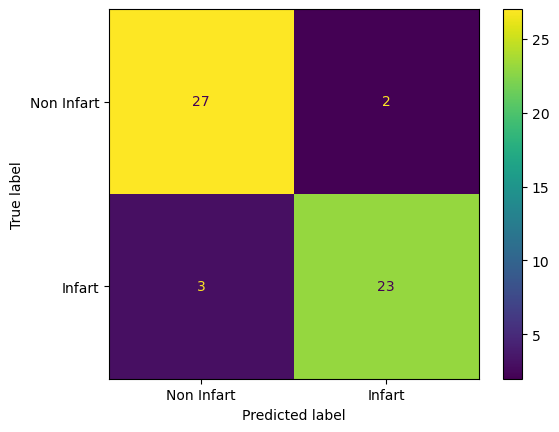

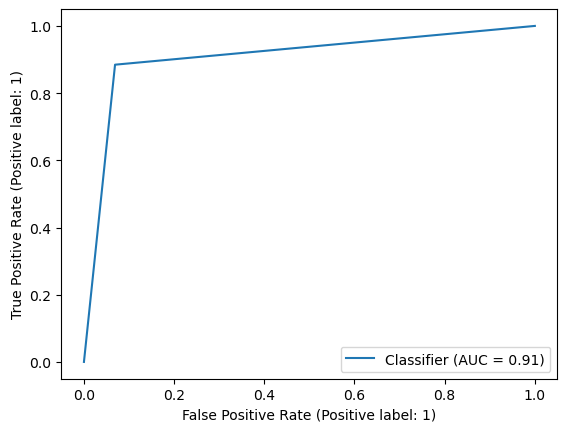

Estimator 24


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




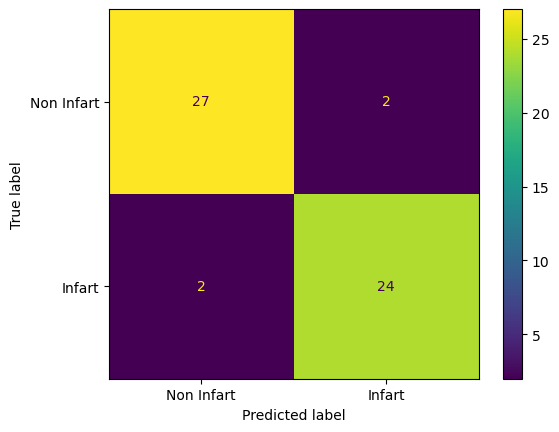

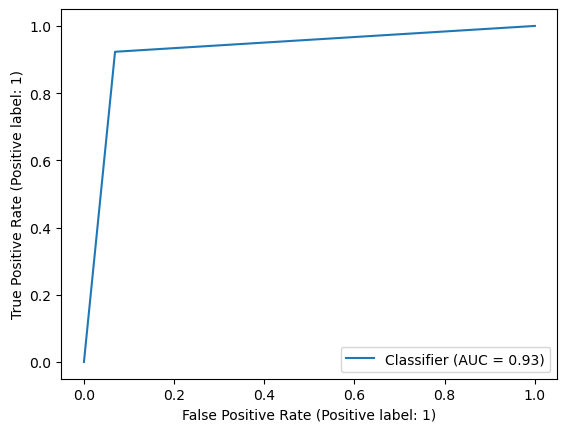

Estimator 25


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




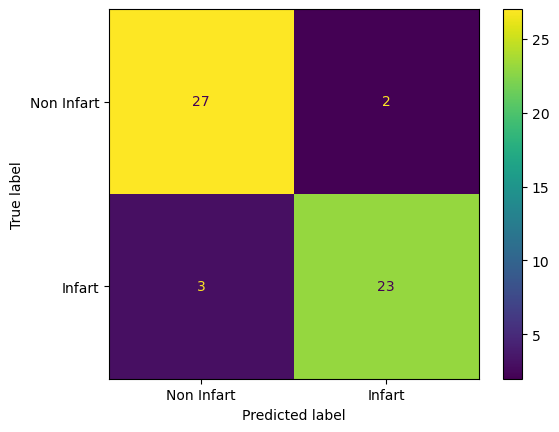

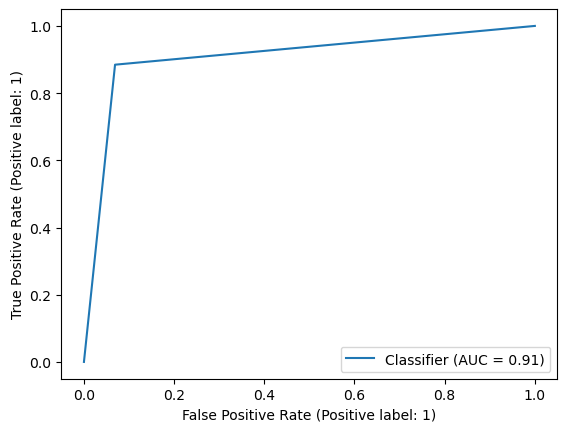

Estimator 26


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




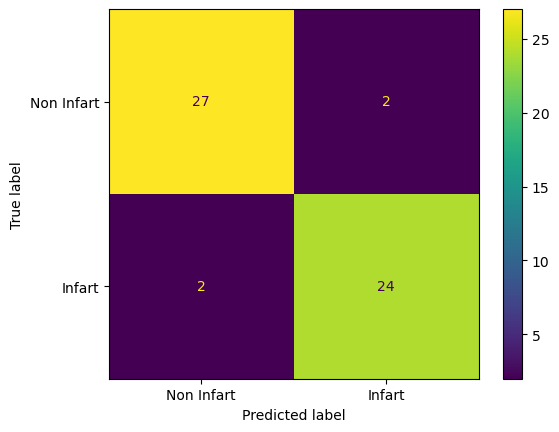

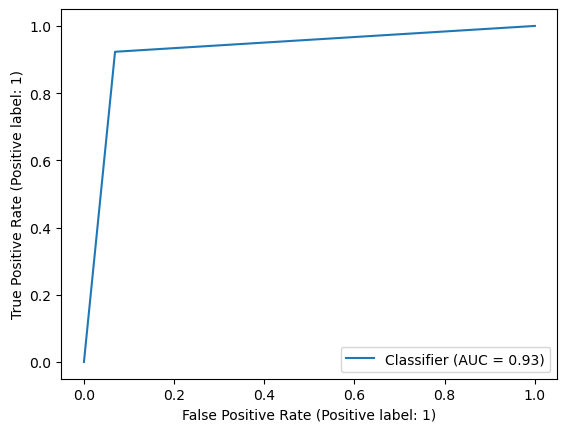

Estimator 27


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




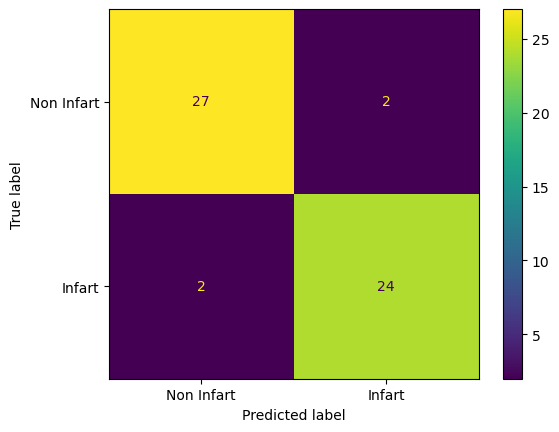

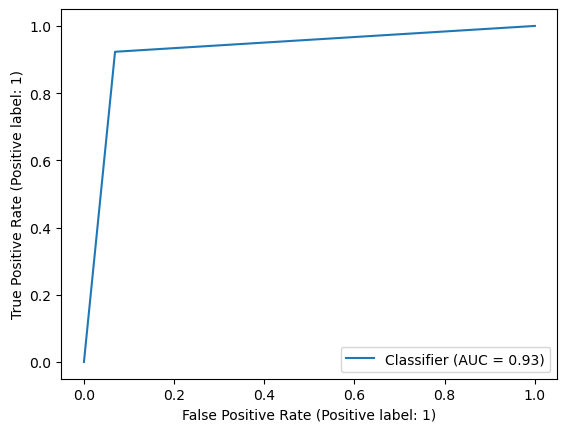

Estimator 28


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




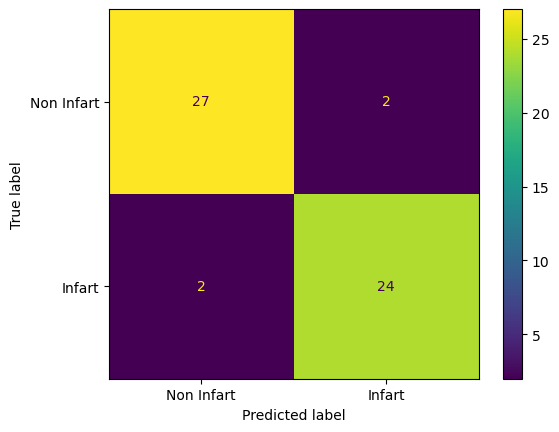

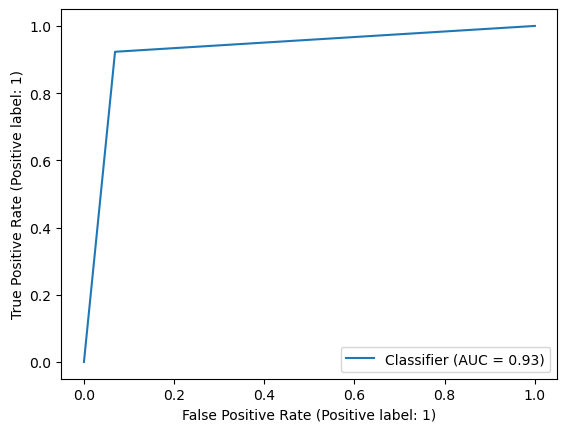

Estimator 29


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




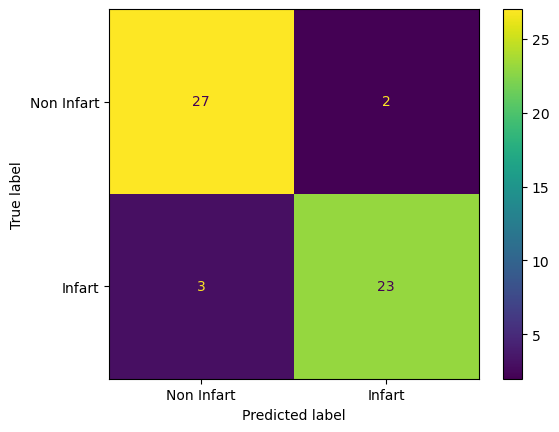

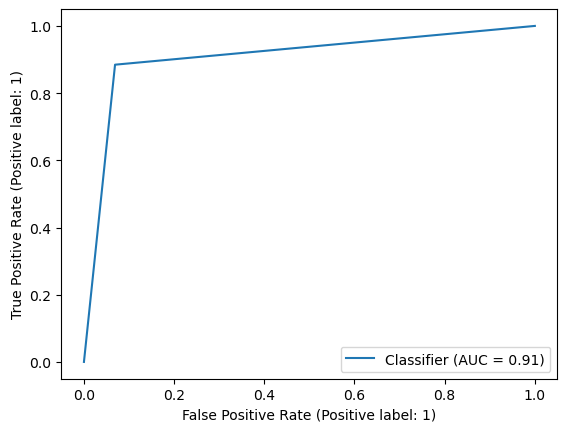

Estimator 30


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




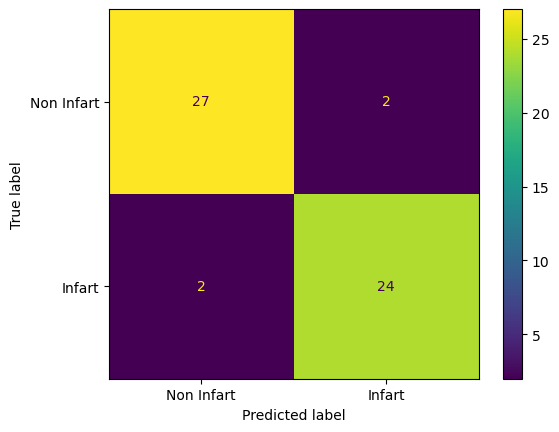

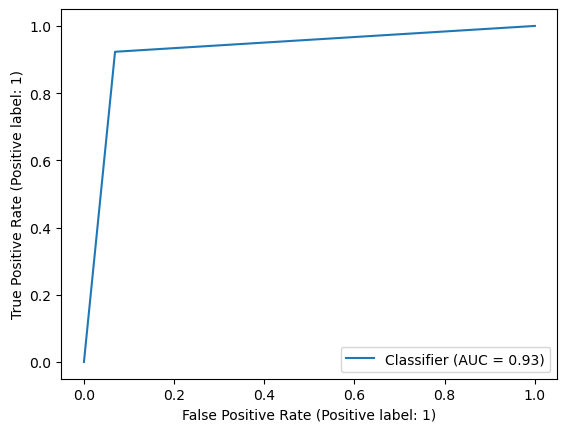

Estimator 31


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




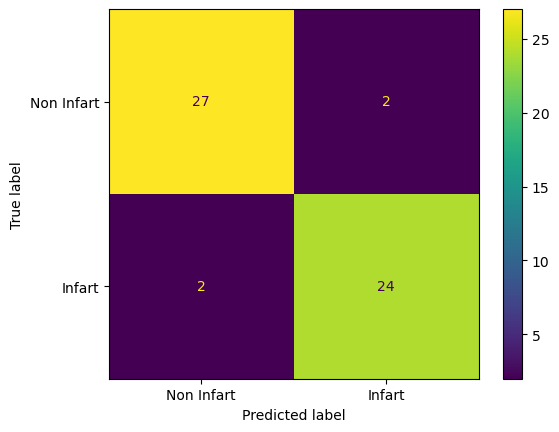

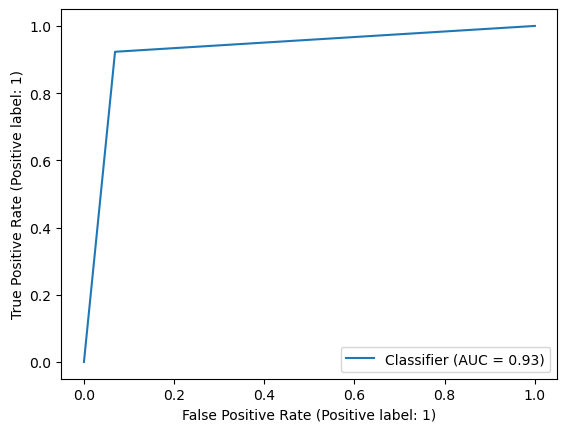

Estimator 32


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




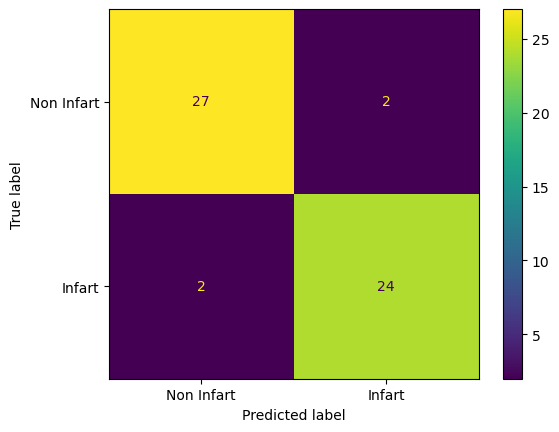

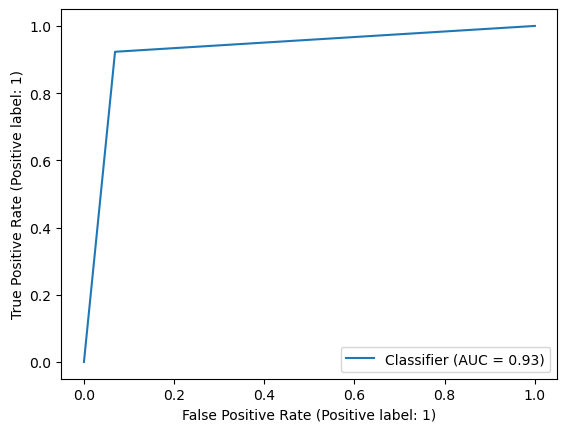

Estimator 33


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




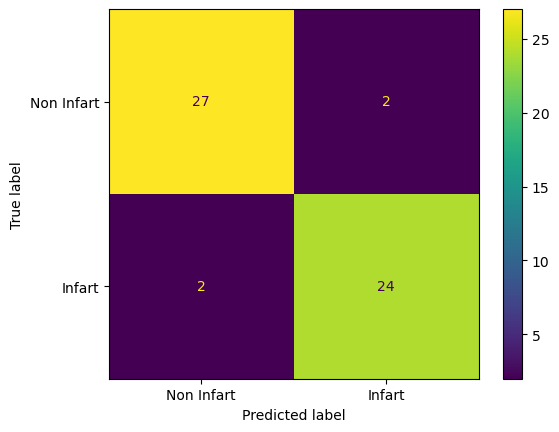

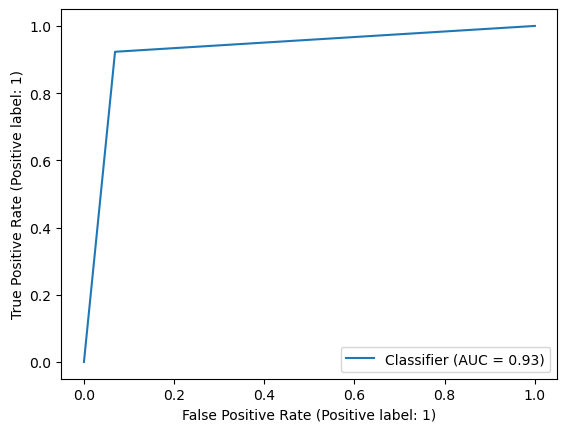

Estimator 34


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




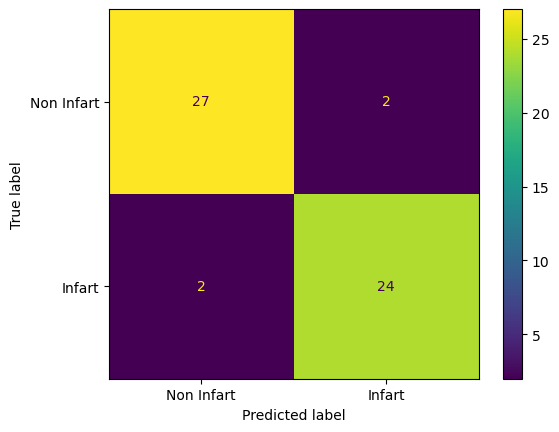

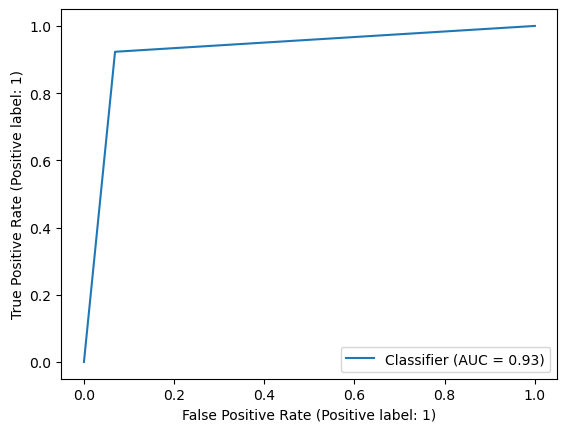

Estimator 35


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




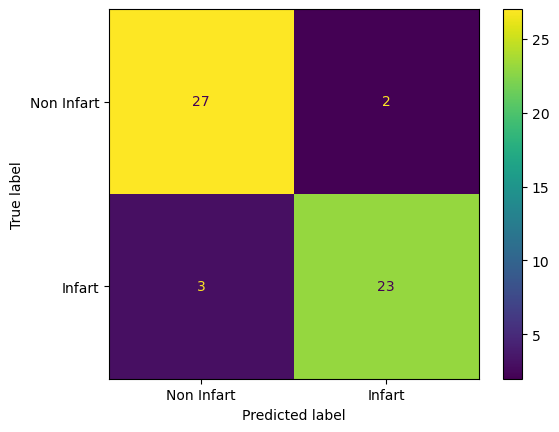

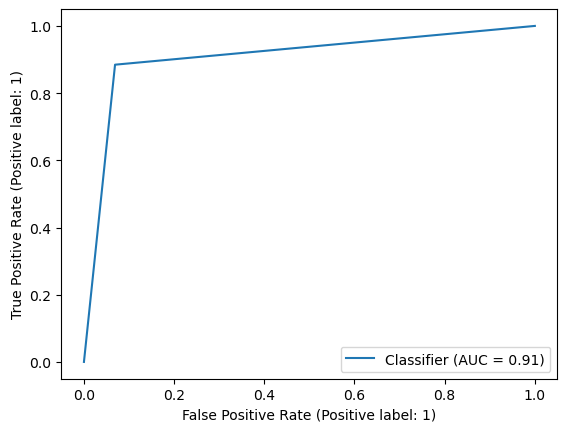

Estimator 36


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




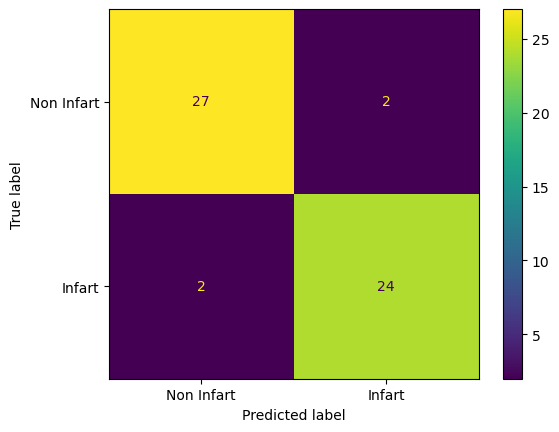

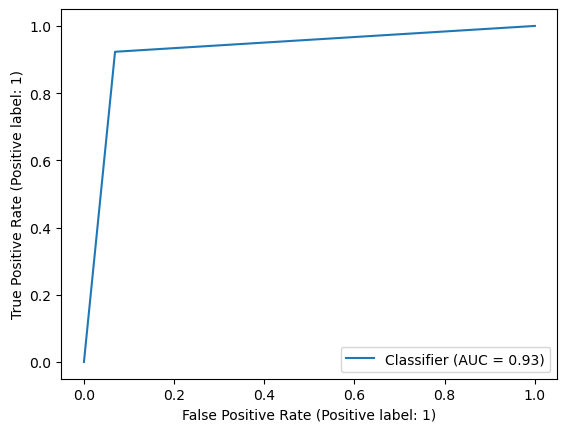

Estimator 37


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




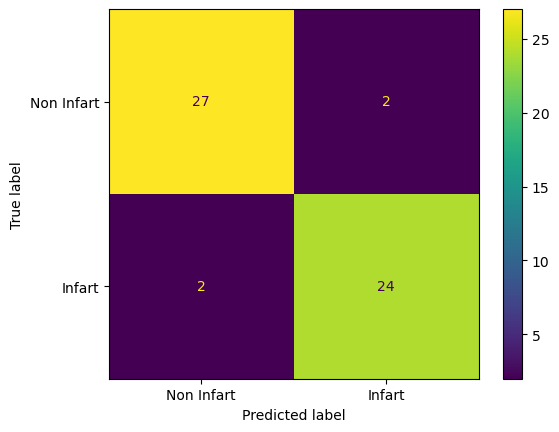

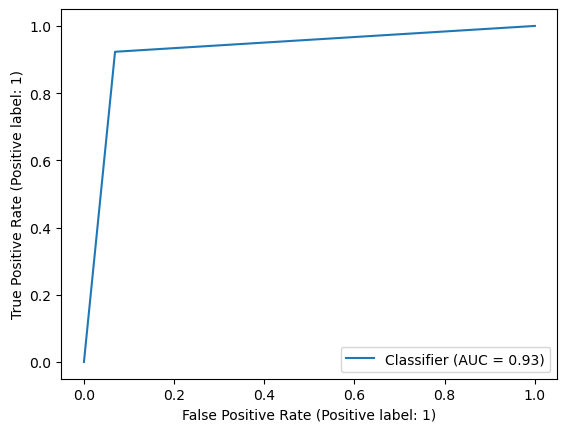

Estimator 38


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




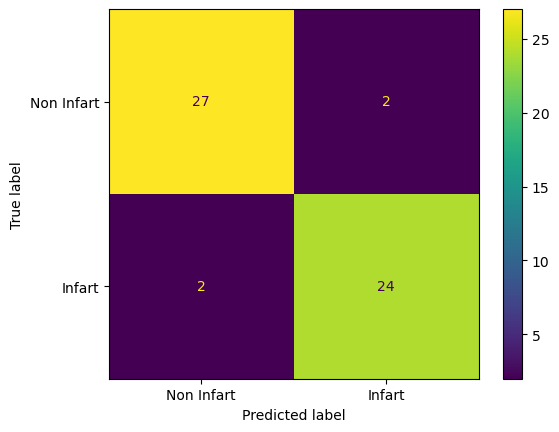

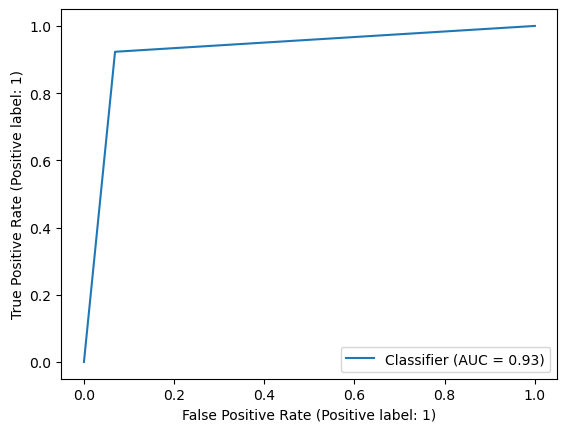

Estimator 39


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




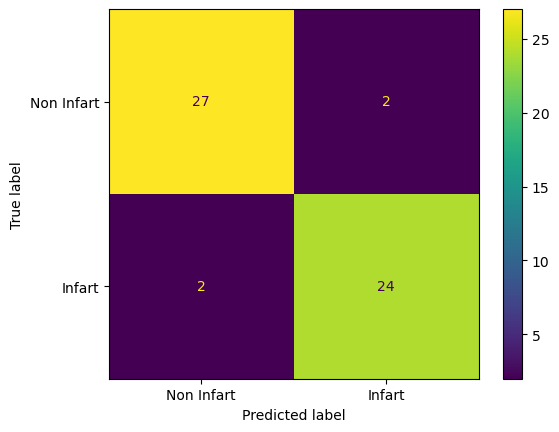

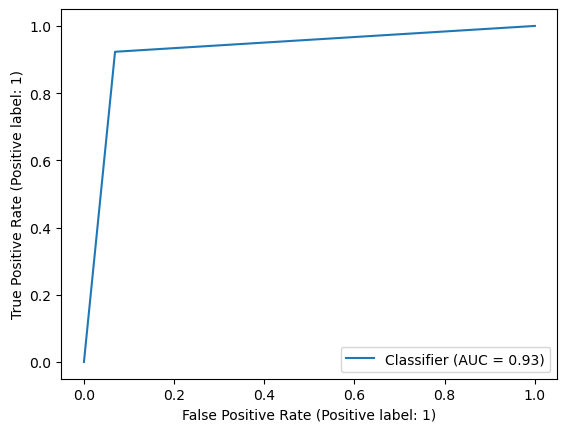

Estimator 40


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




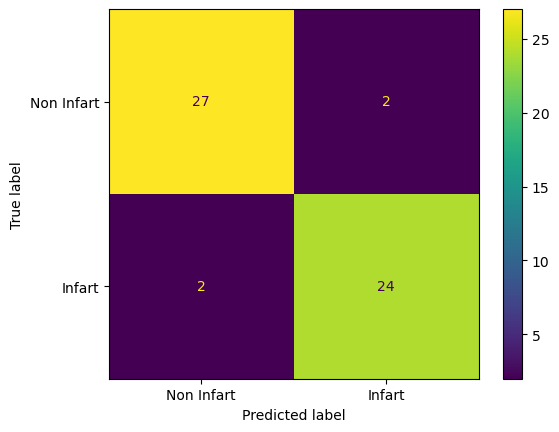

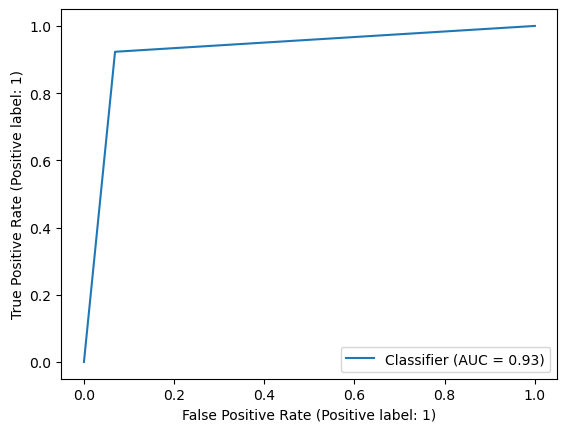

Estimator 41


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




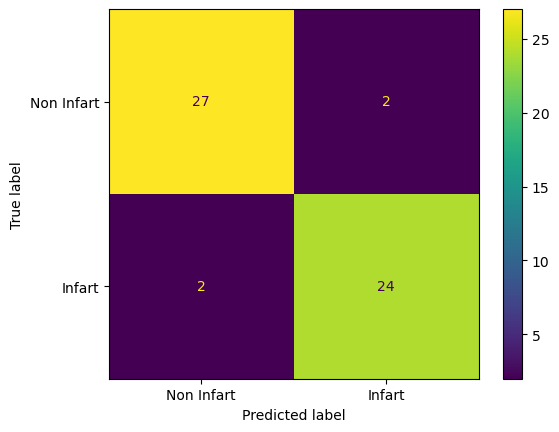

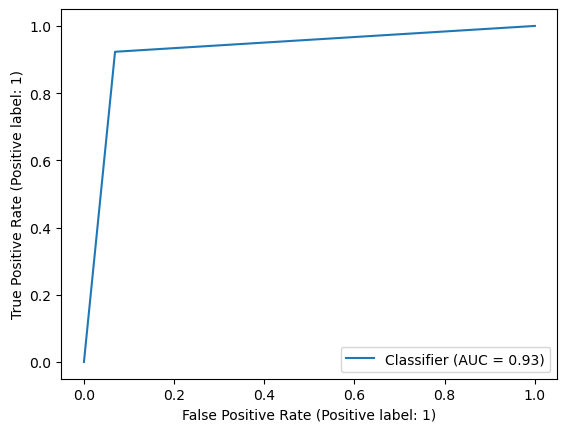

Estimator 42


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




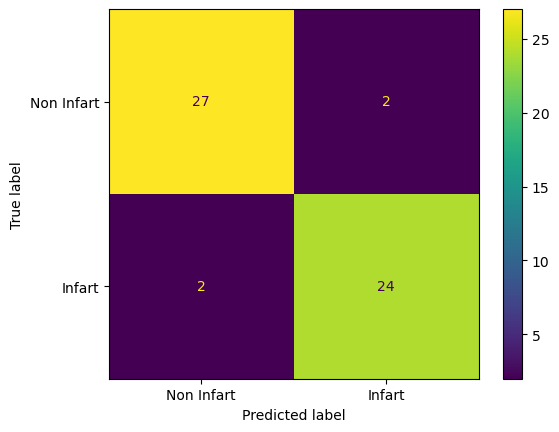

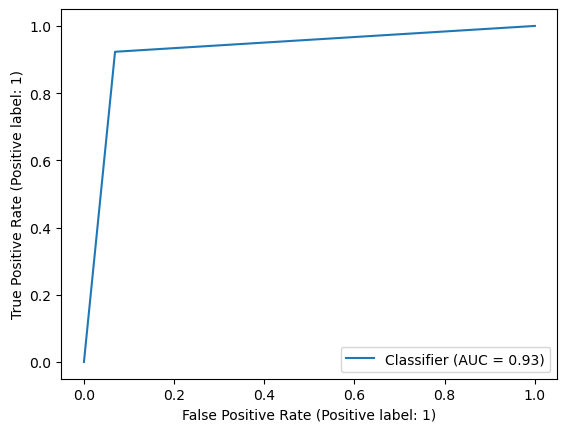

Estimator 43


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




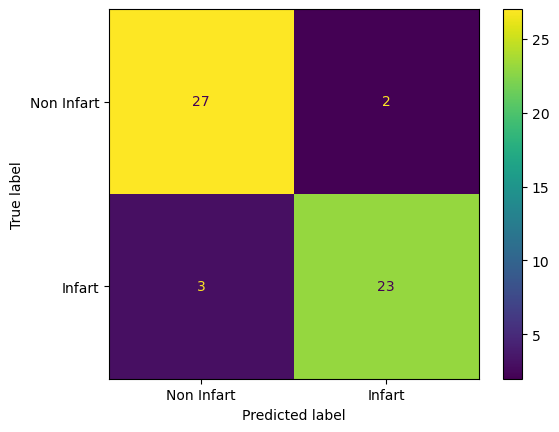

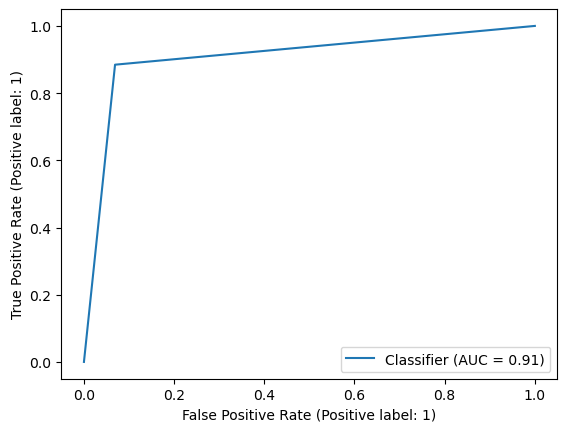

Estimator 44


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




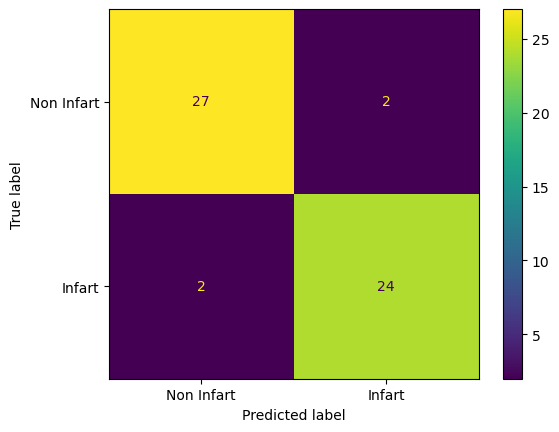

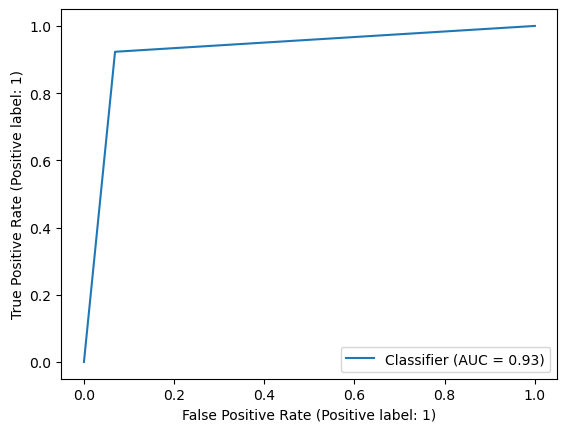

Estimator 45


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




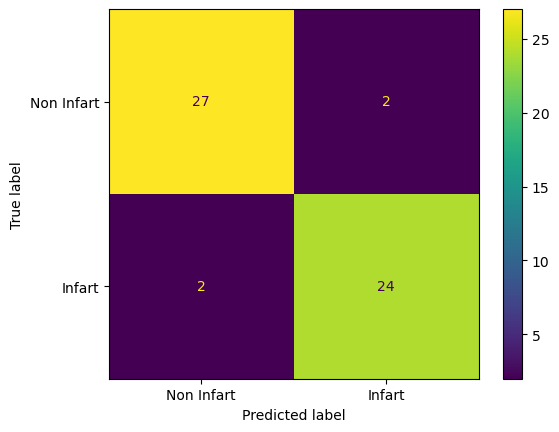

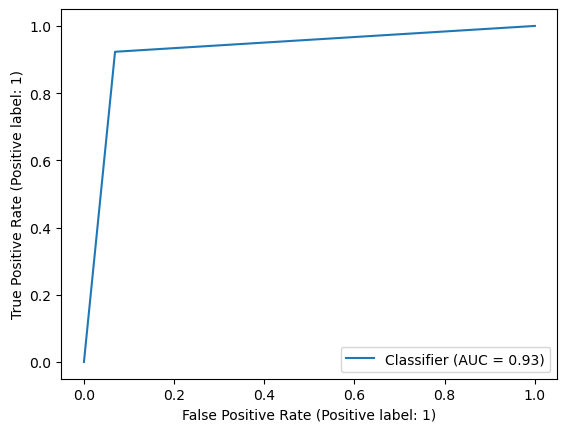

Estimator 46


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




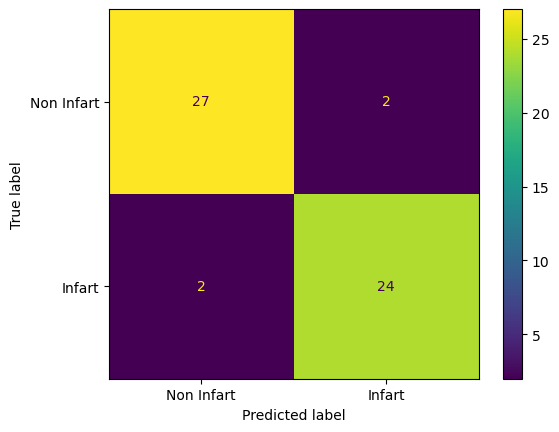

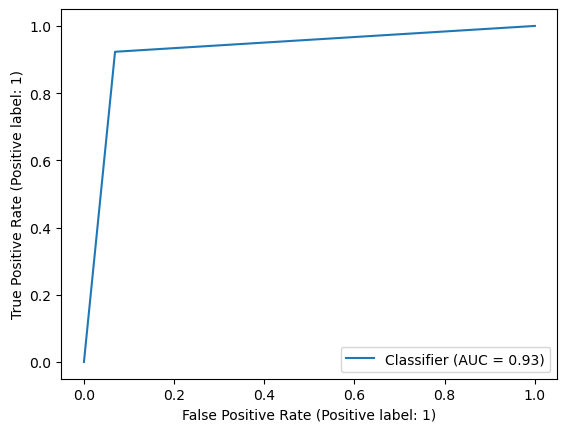

Estimator 47


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




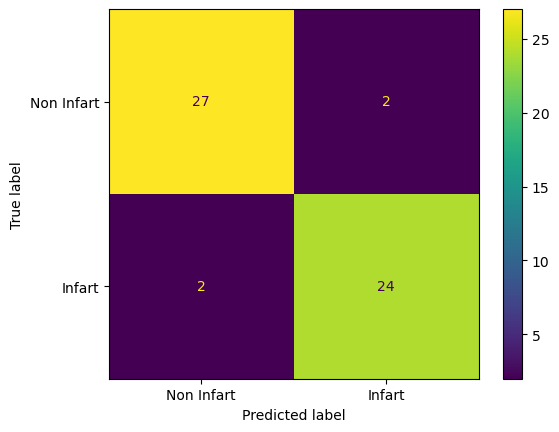

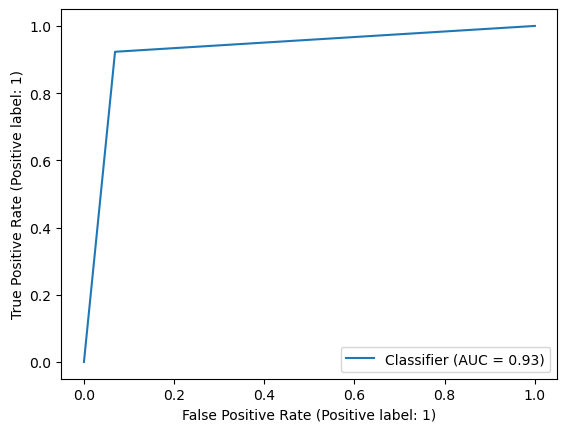

Estimator 48


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




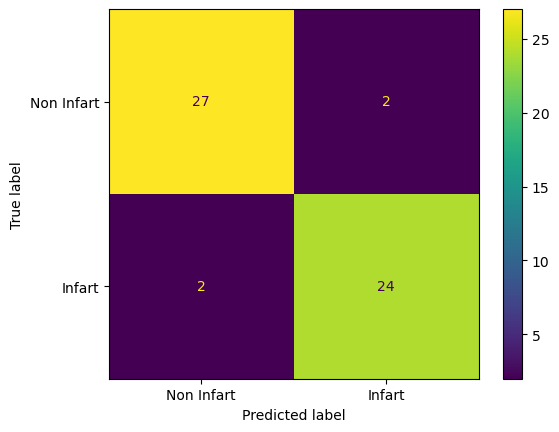

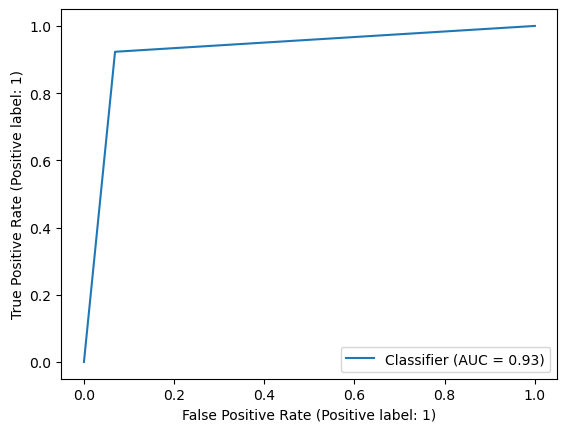

Estimator 49


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




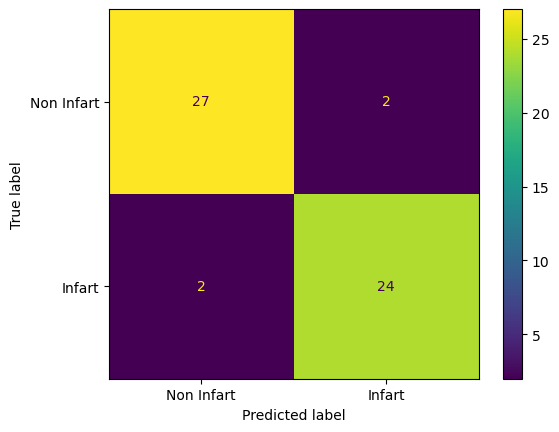

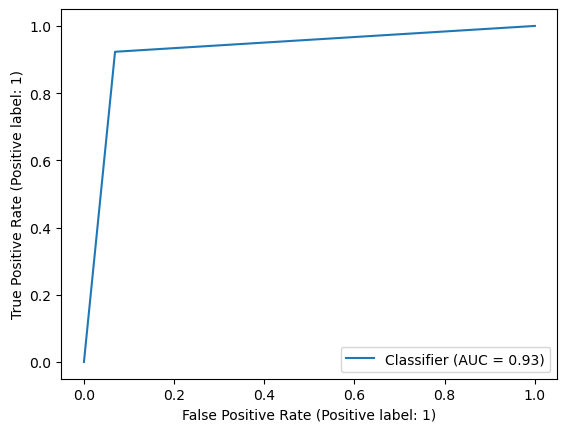

Estimator 50


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




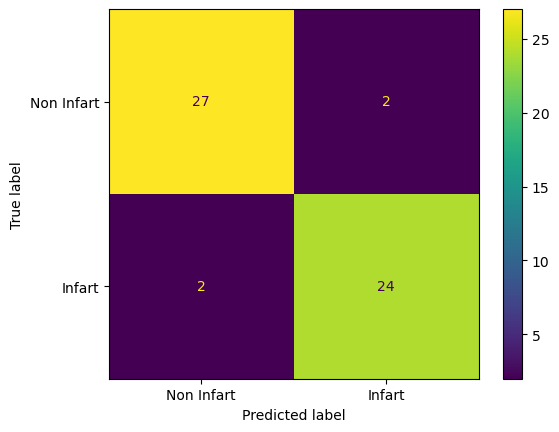

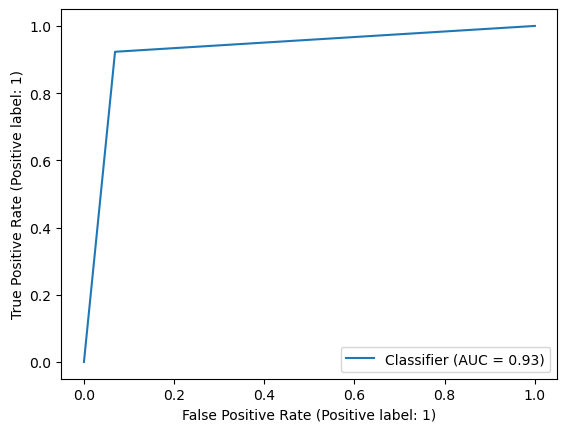

Estimator 51


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




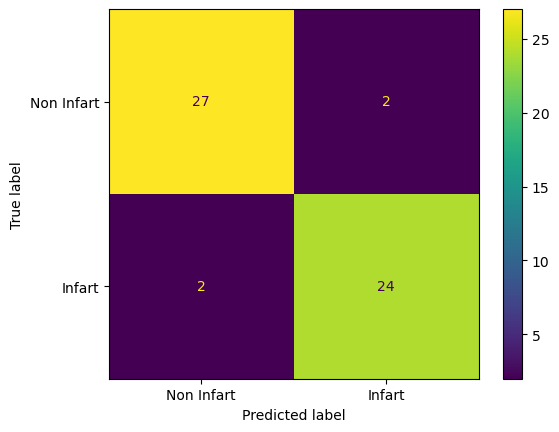

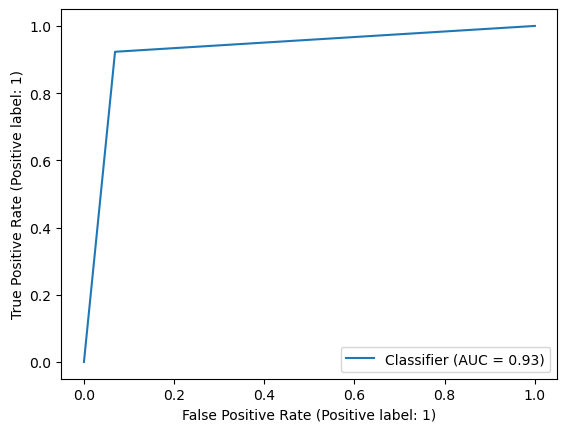

Estimator 52


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




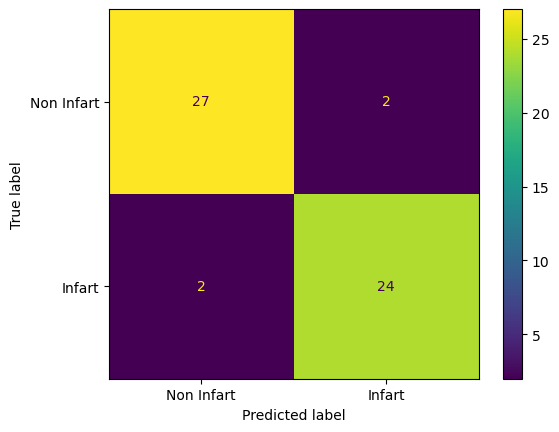

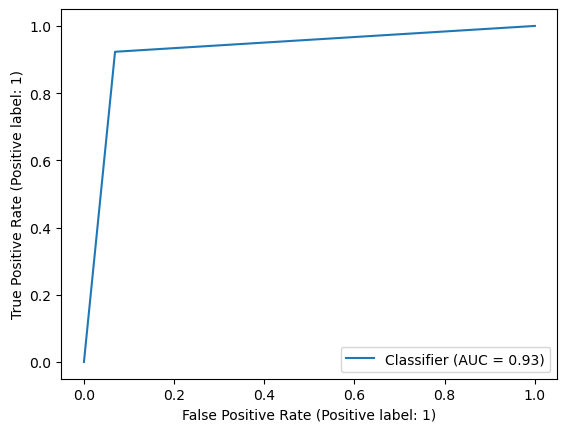

Estimator 53


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846
False Positive rate: 0.06896551724137934




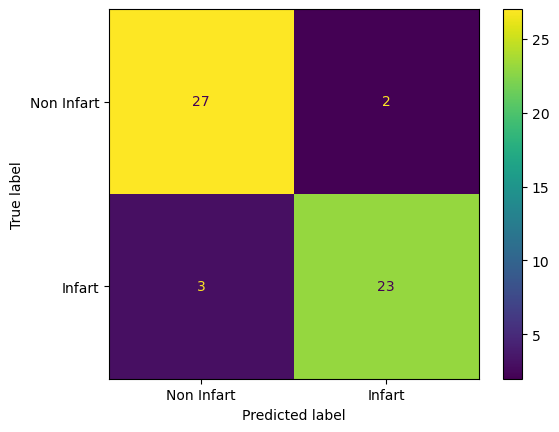

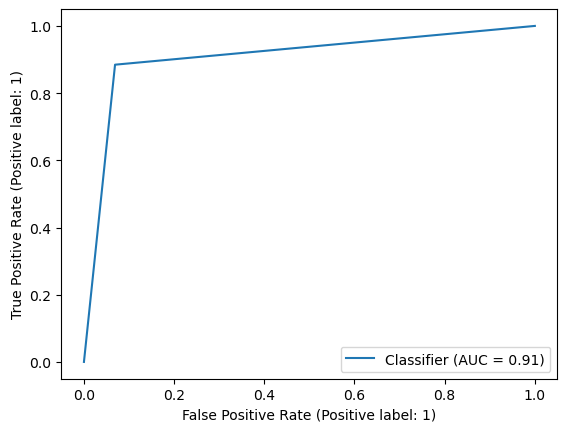

Estimator 54


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231
False Positive rate: 0.06896551724137934




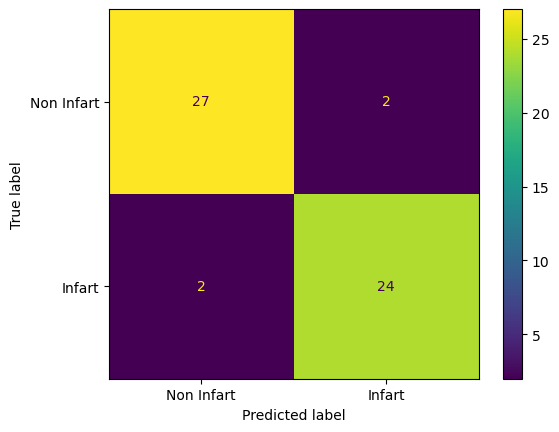

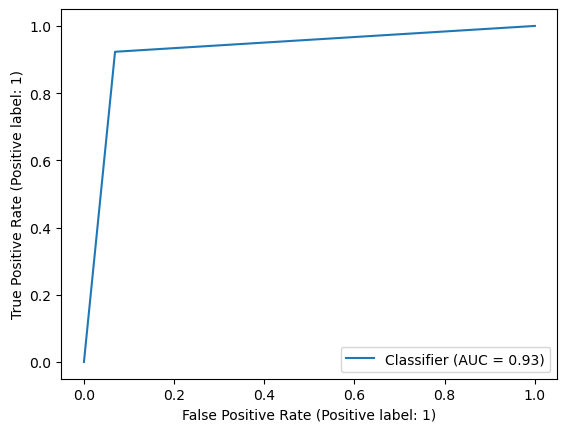

Mean Specificity= 0.9310344827586206 Std: 1.1102230246251565e-16
Mean Sensibility= 0.9146853146853144  Std: 0.01588505830993087


In [35]:
# Verificando a media com todos os elementos e classificadores
list_sensibility = []
list_specificity = []
list_false_positive_rate = []

for i, estimator in enumerate(scores['estimator']):
    print(f'Estimator {i}\n\n')
    X_pred = X_train
    y_truth = y.values
    y_pred = estimator.predict(X_pred)
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    false_positive_rate = 1 - specificity
    print(f'Number of samples: {len(X_pred)}')
    print(f"Specificity= {specificity}")
    print(f"Sensibility= {sensibility}")
    print(f'False Positive rate: {false_positive_rate}\n\n')
    list_sensibility.append(sensibility)
    list_specificity.append(specificity)
  
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
    show_roc_curve(estimator, y_truth, X_pred)
    plt.grid(False)
    plt.show()

print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")

Accuracy: 0.8


Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077


False Positive rate: 0.03448275862068961


TypeError: show_roc_curve() missing 1 required positional argument: 'X'

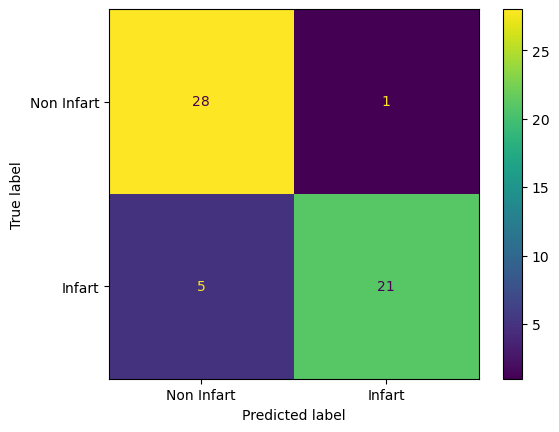

In [39]:
model = KNeighborsClassifier()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_train, y.values)

Accuracy: 0.7272727272727273


Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


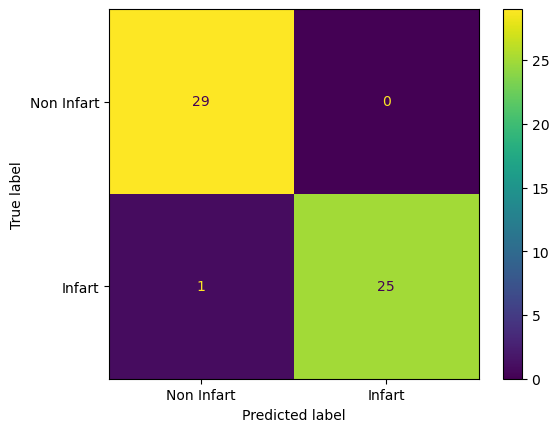

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


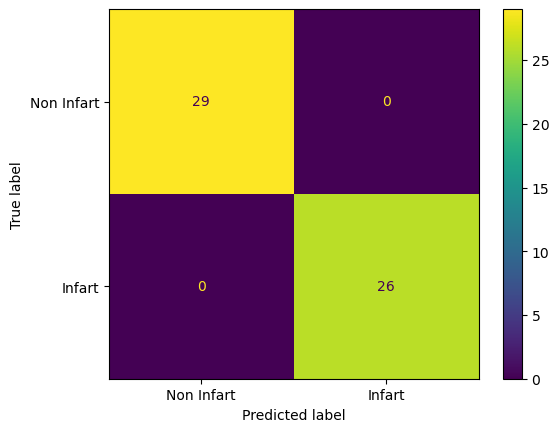

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


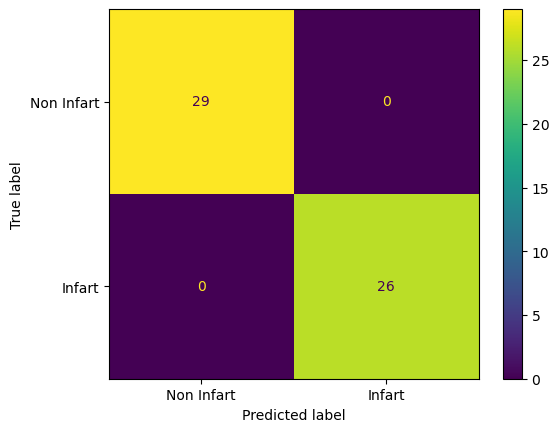

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


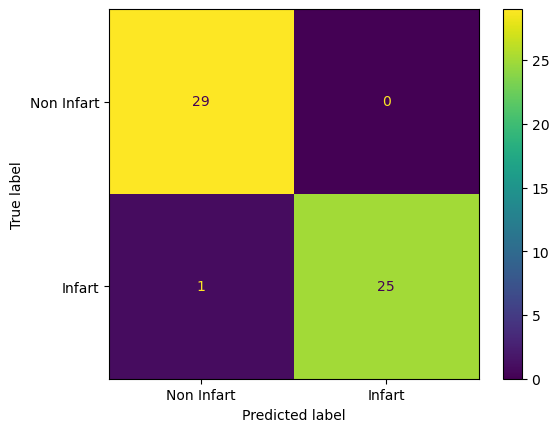

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


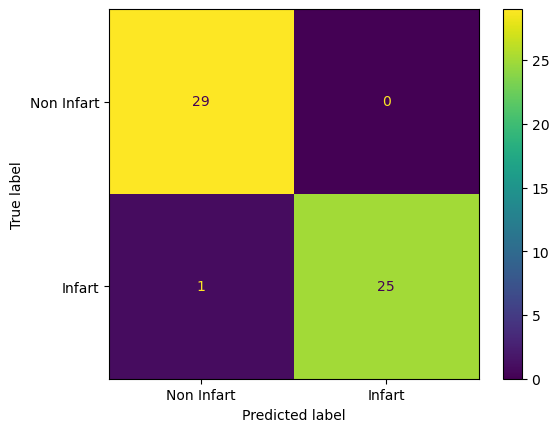

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


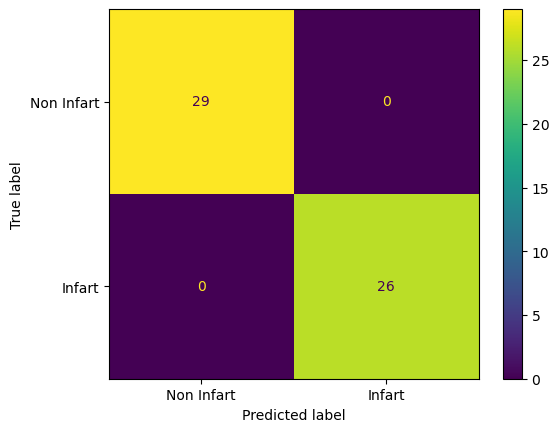

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


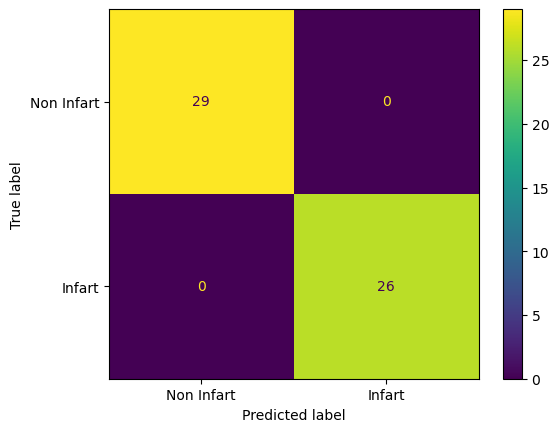

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


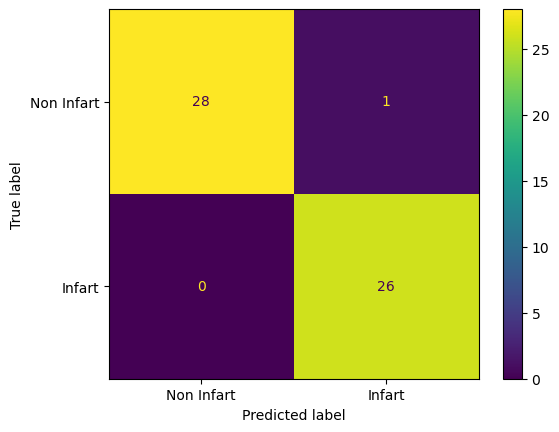

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


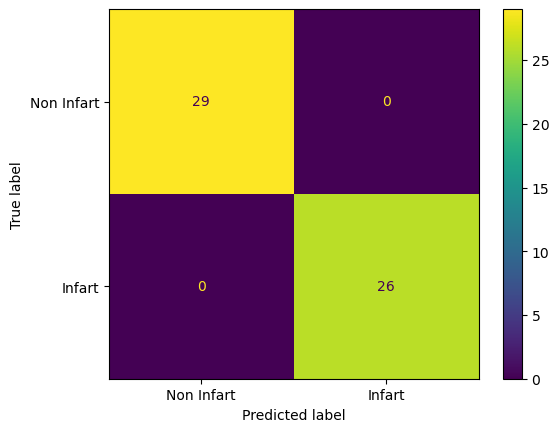

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


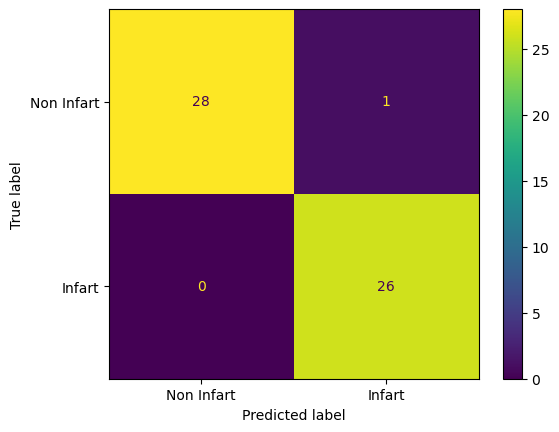

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


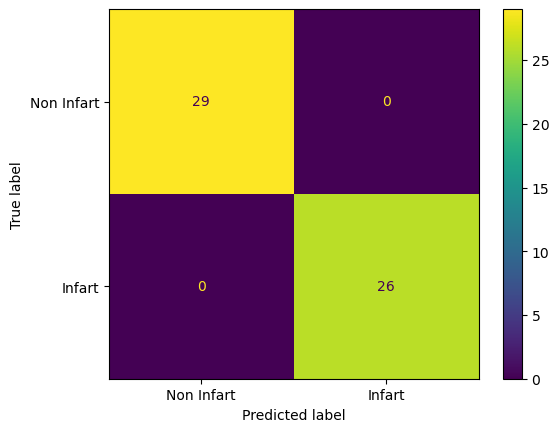

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


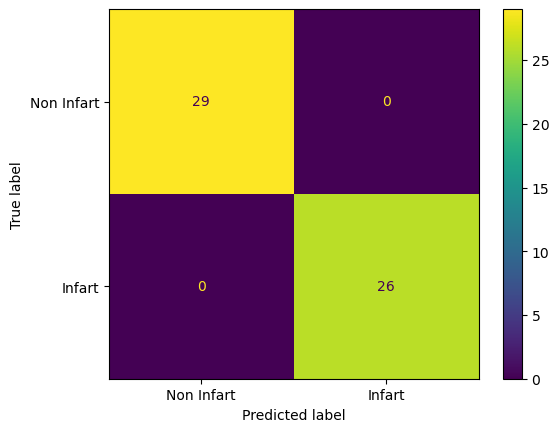

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


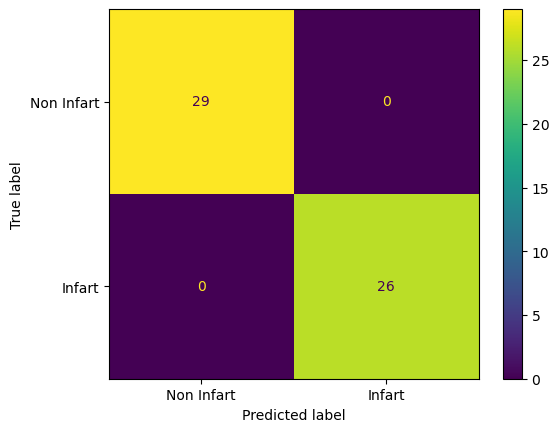

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


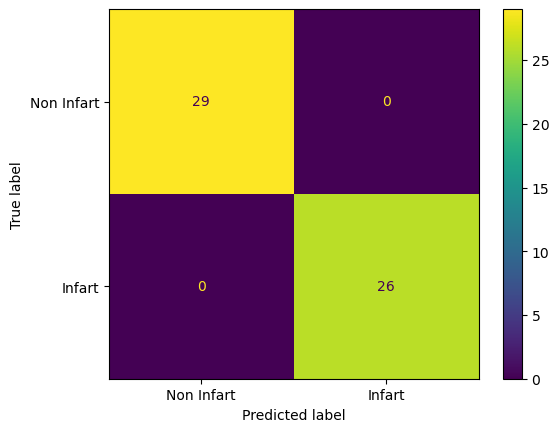

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


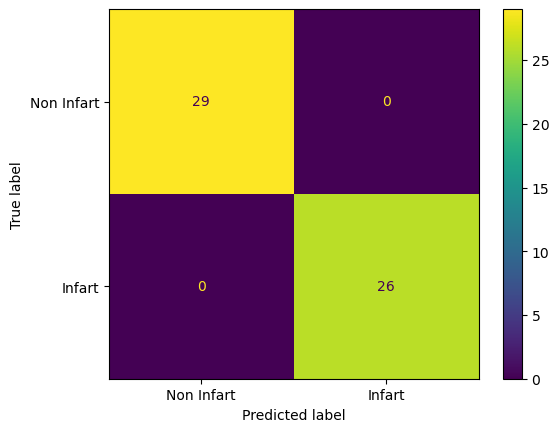

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


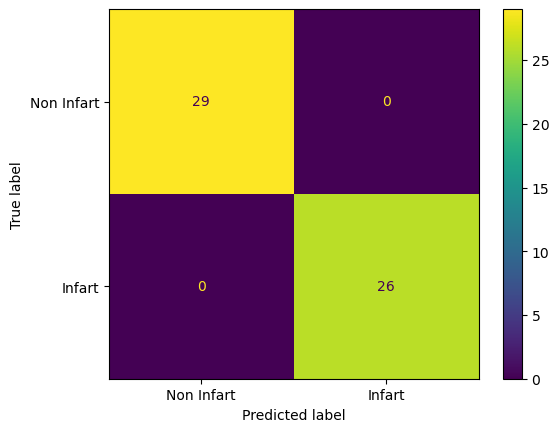

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


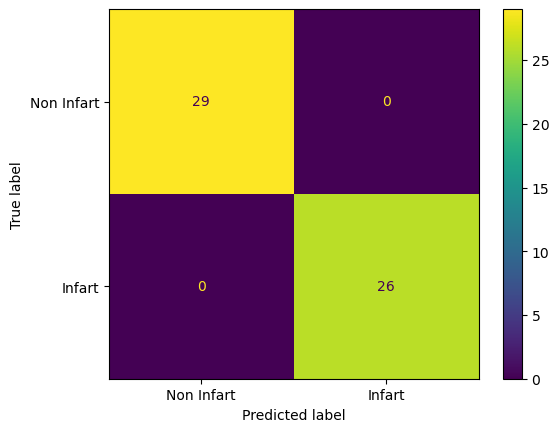

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


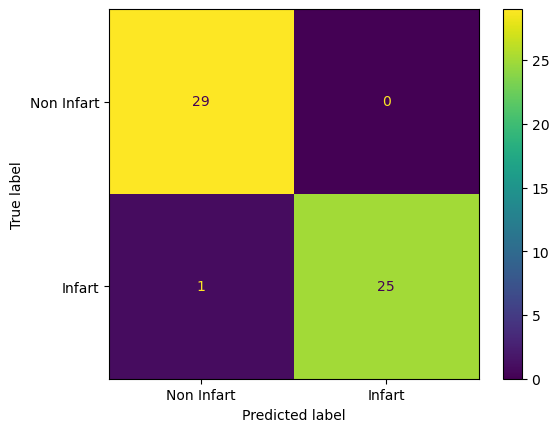

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


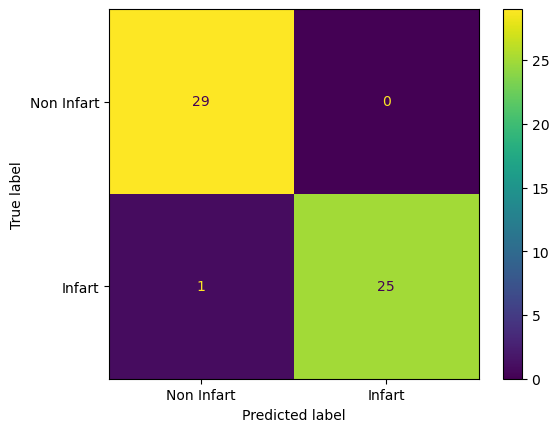

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


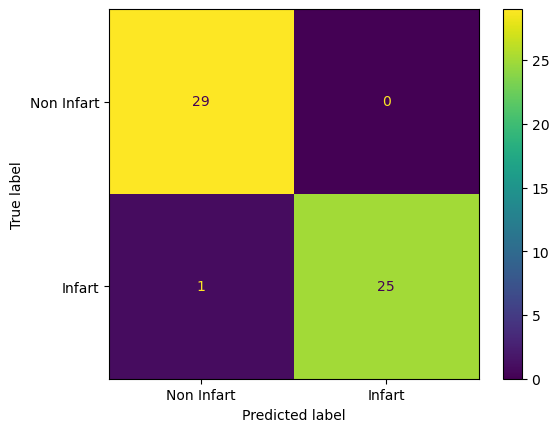

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


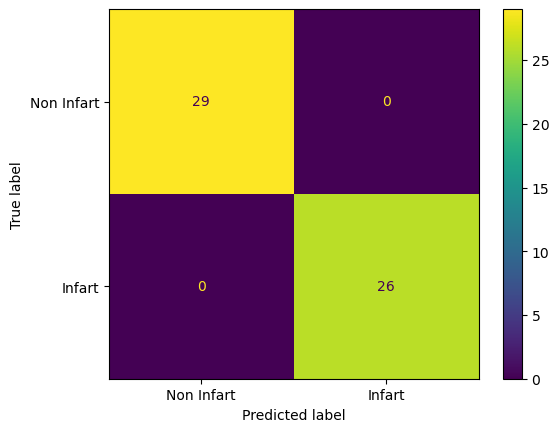

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


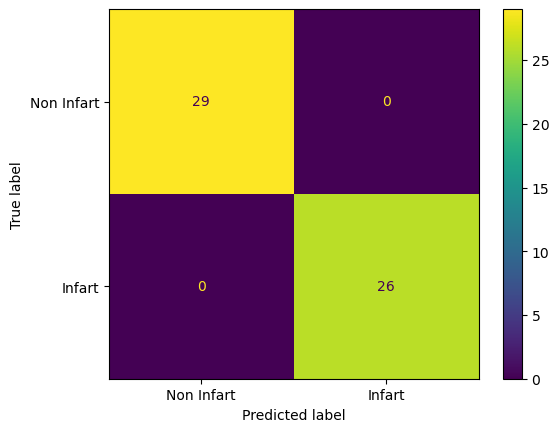

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


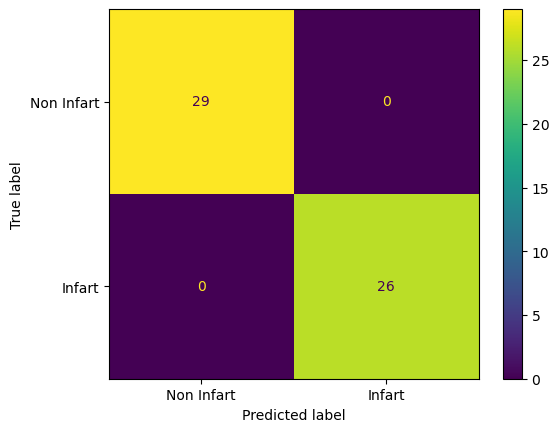

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


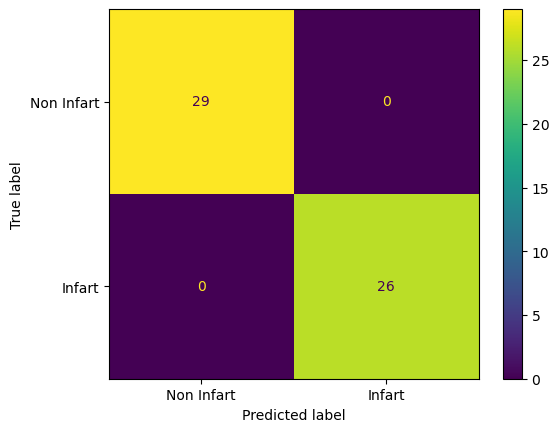

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


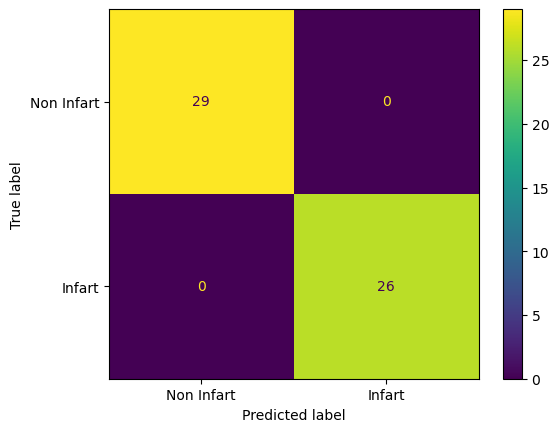

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


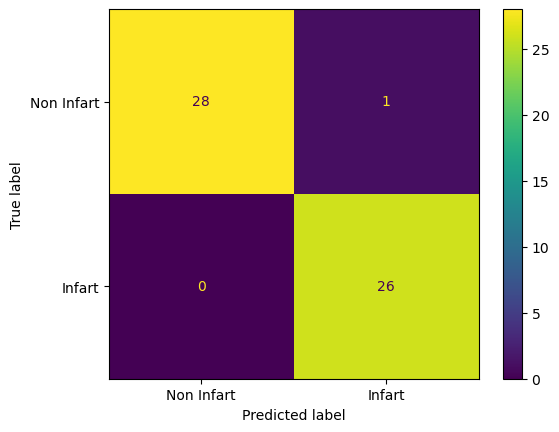

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


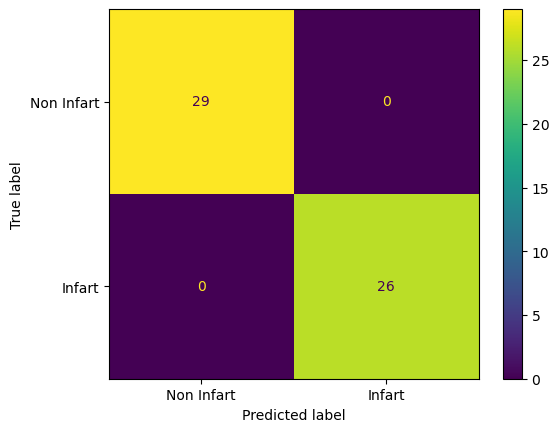

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


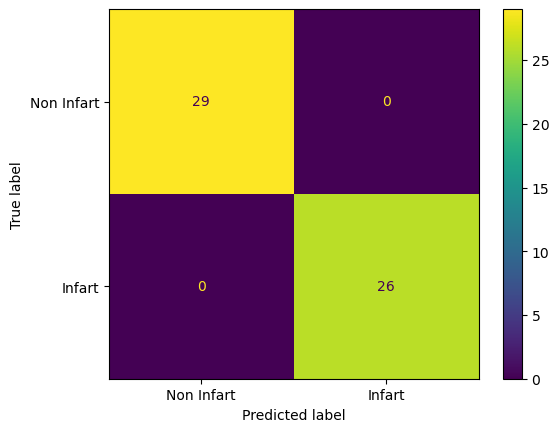

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


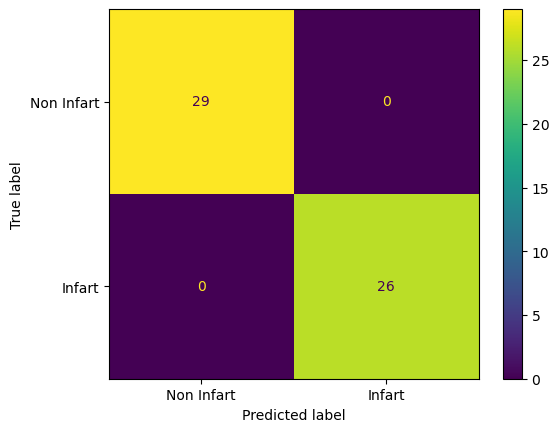

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


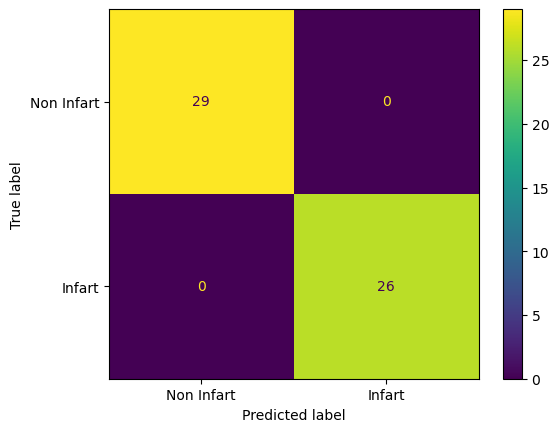

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


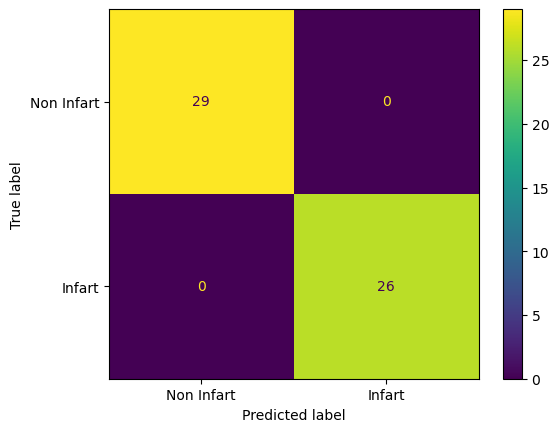

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


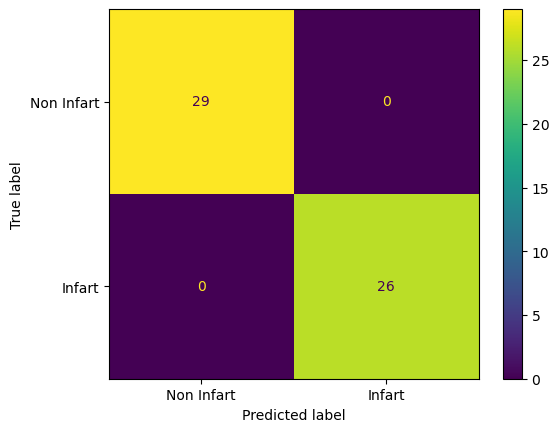

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


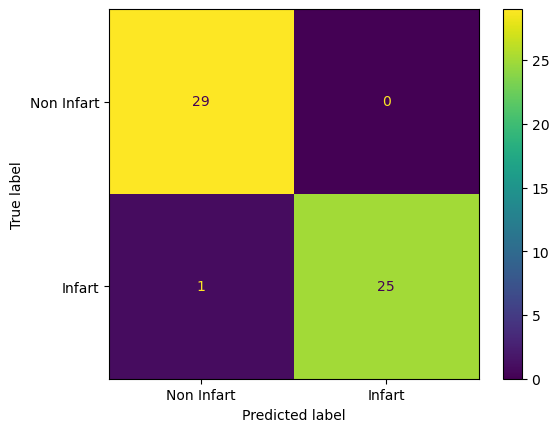

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


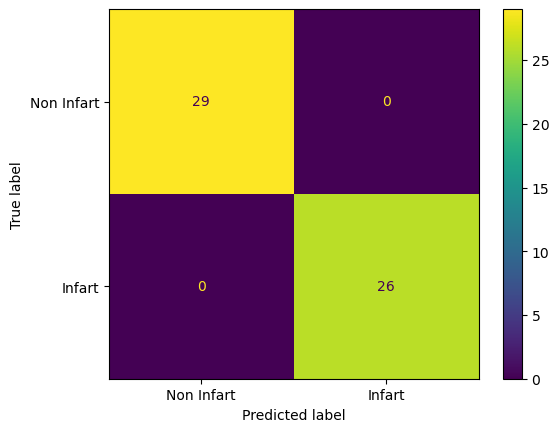

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


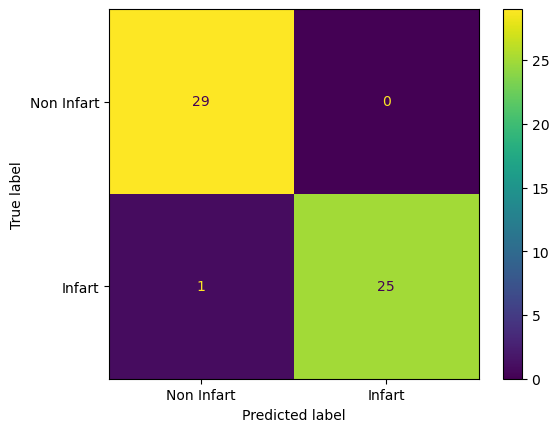

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


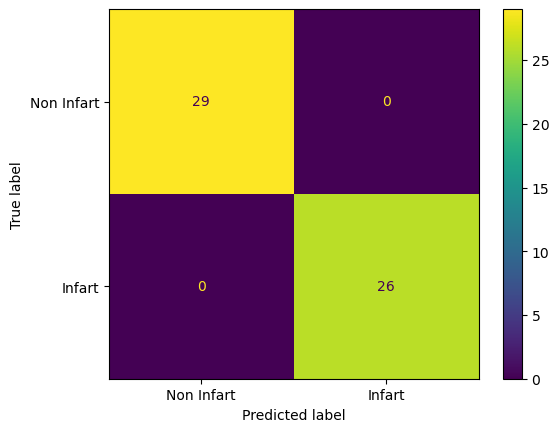

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


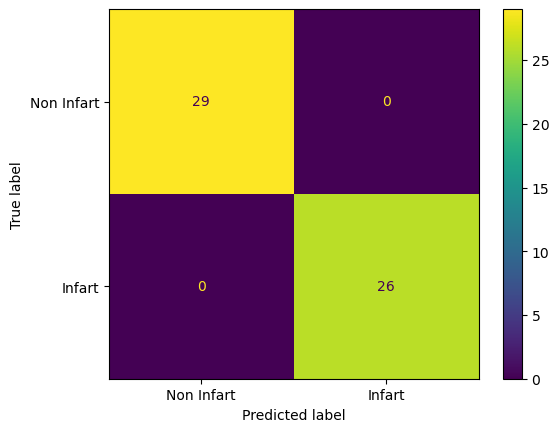

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


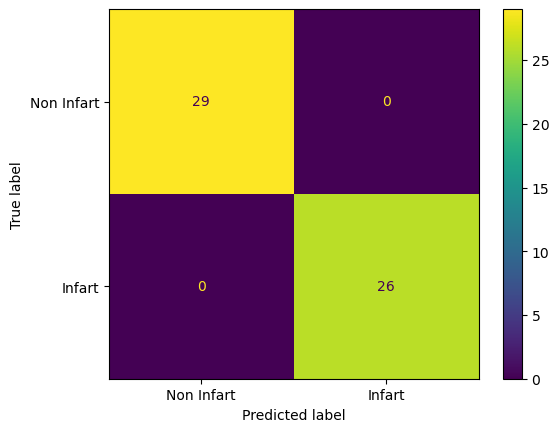

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


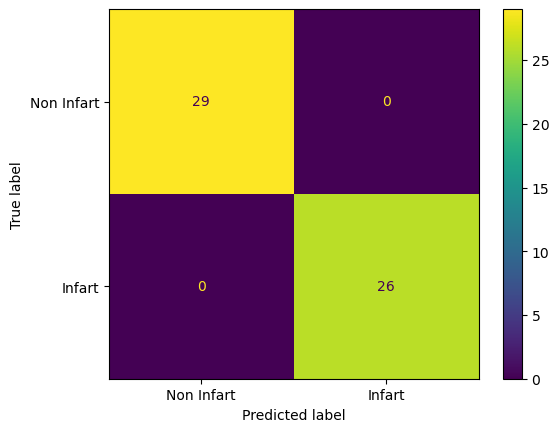

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


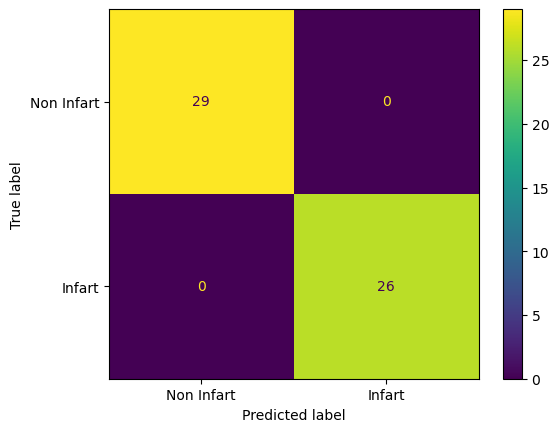

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


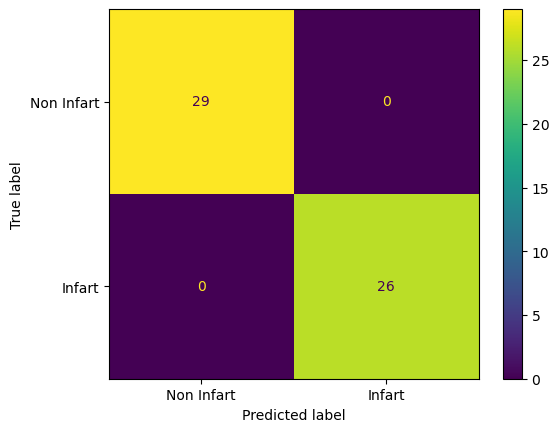

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


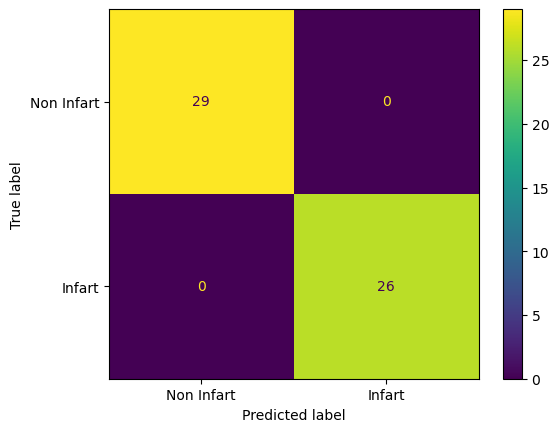

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


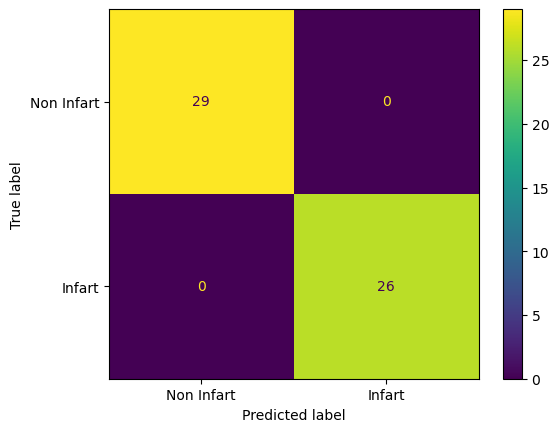

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9615384615384616


False Positive rate: 0.0


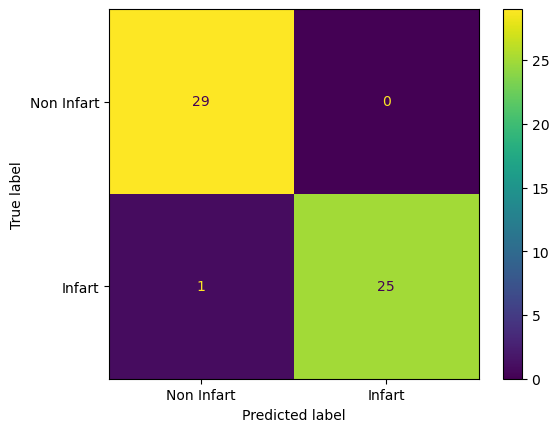

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


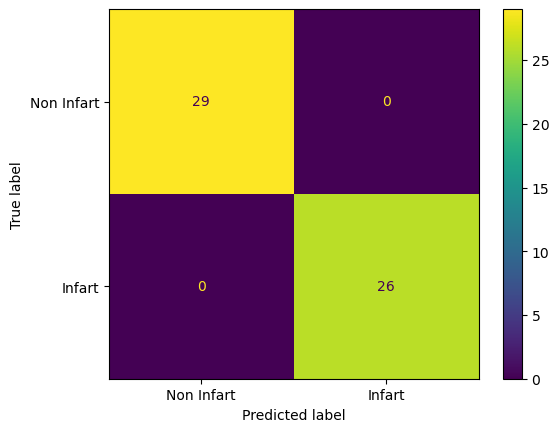

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


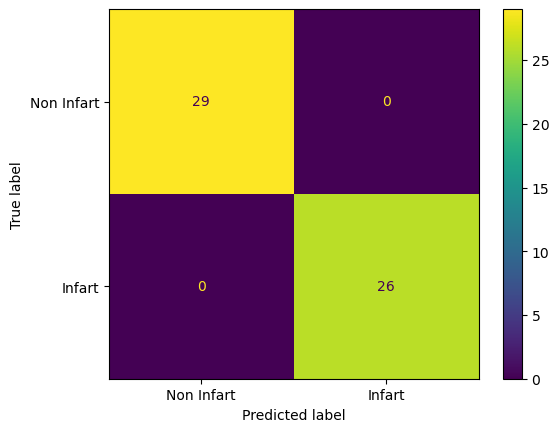

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


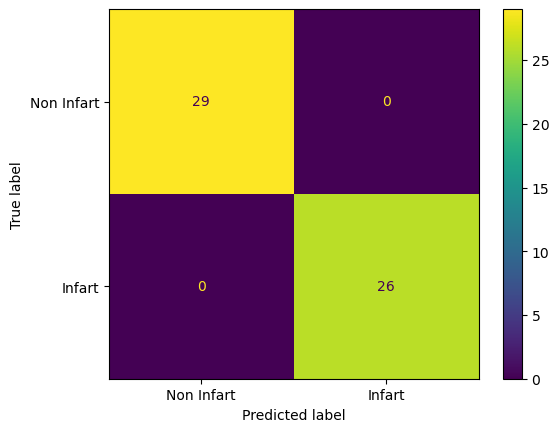

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


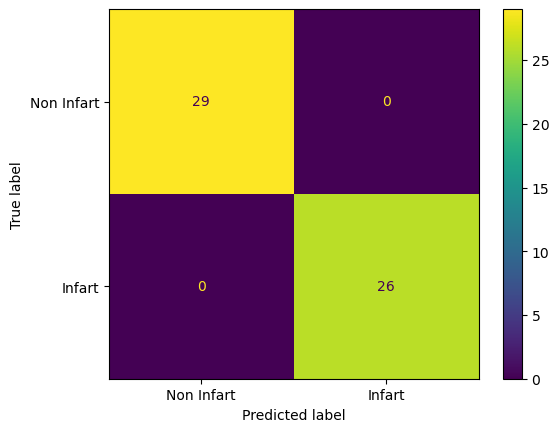

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


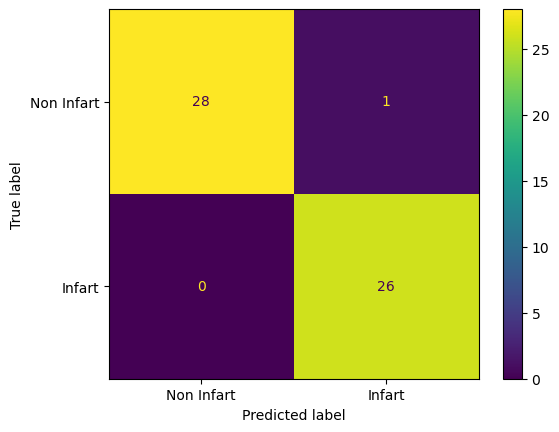

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


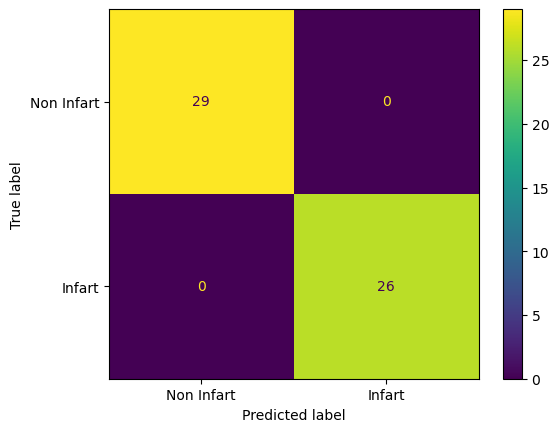

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


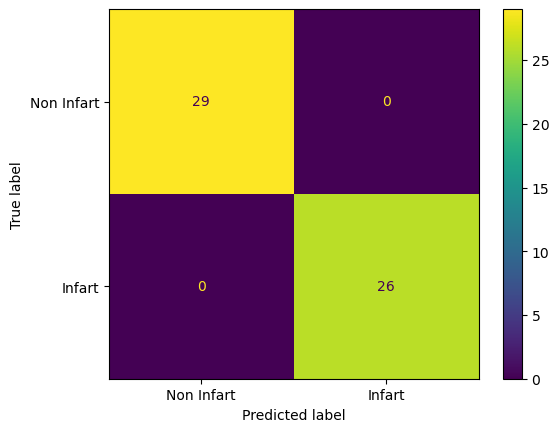

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


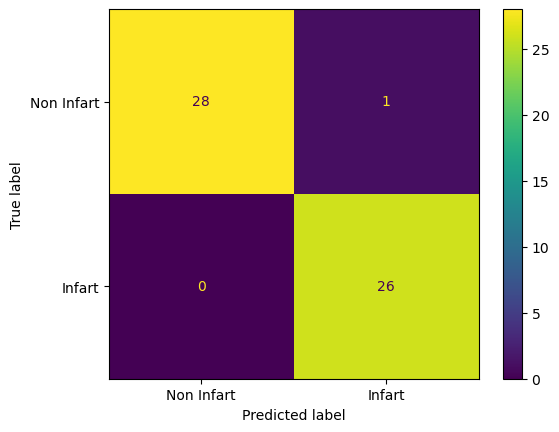

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


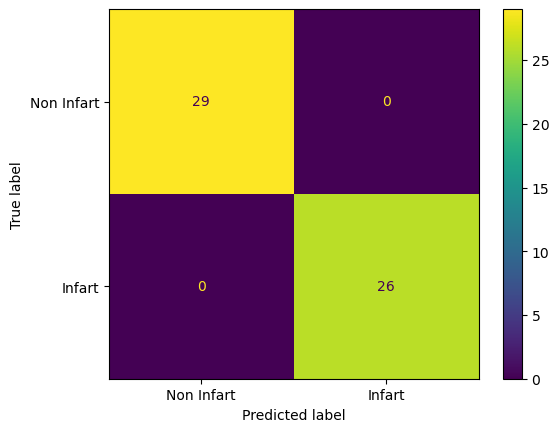

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 1.0


False Positive rate: 0.03448275862068961


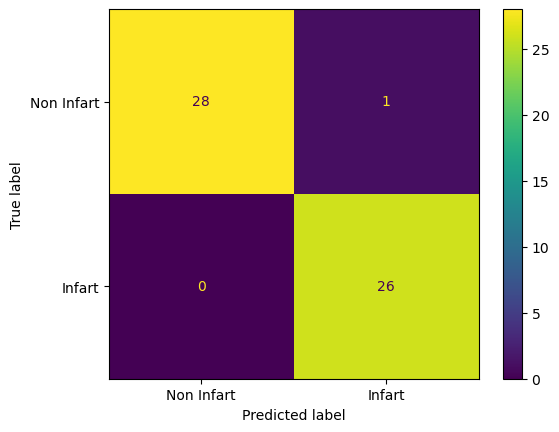

Number of samples: 55
Specificity= 1.0
Sensibility= 1.0


False Positive rate: 0.0


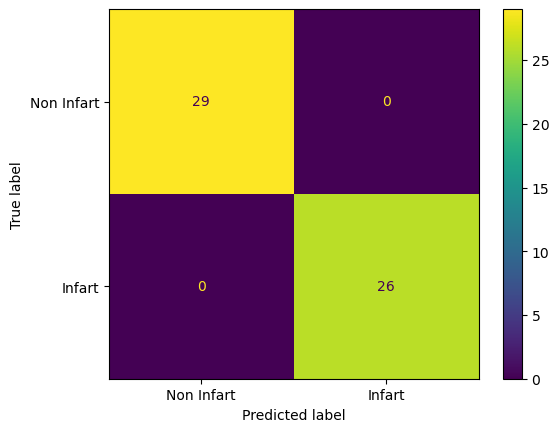

Mean Specificity= 0.9962382445141065 Std: 0.01075011172381331
Mean Sensibility= 0.9937062937062937  Std: 0.01422866430026279


In [28]:
model = DecisionTreeClassifier()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_total=X_train, y_total=y.values)

Accuracy: 0.8181818181818181


Fold 0
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




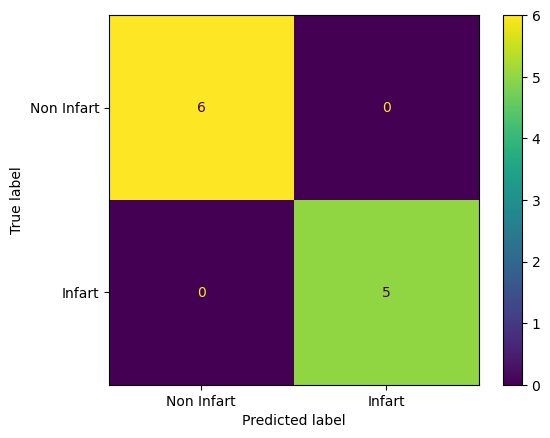

Fold 1
Number of samples: 11
Mean Specificity= 0.875
Mean Sensibility= 0.6666666666666666




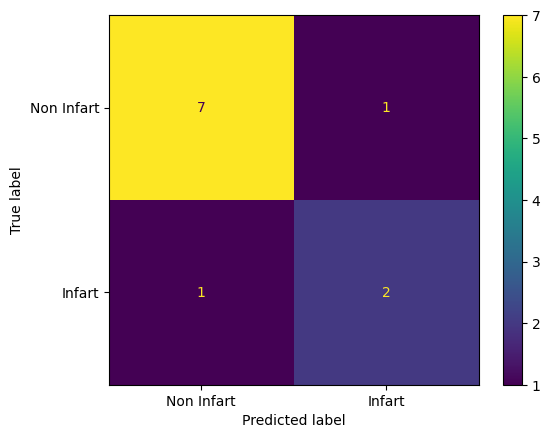

Fold 2
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.8333333333333334




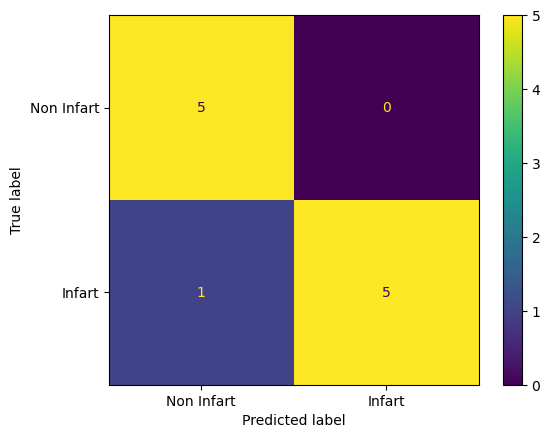

Fold 3
Number of samples: 11
Mean Specificity= 0.8
Mean Sensibility= 0.8333333333333334




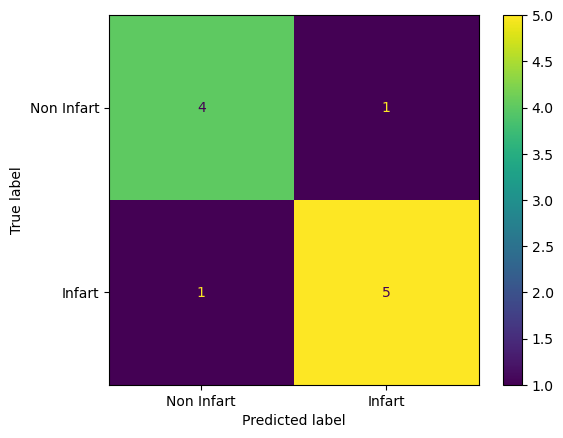

Fold 4
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.6666666666666666




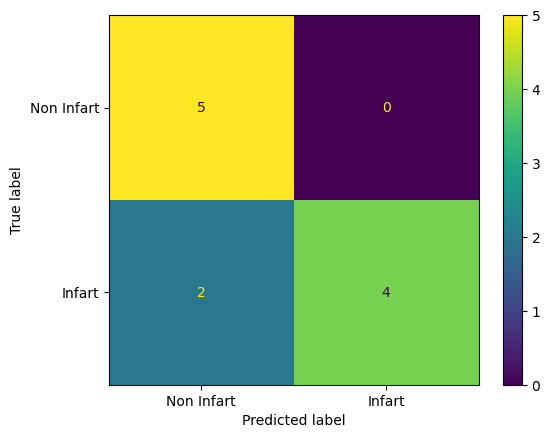

Mean Specificity= 0.9349999999999999 Std: 0.08306623862918074
Mean Sensibility= 0.8  Std: 0.12472191289246473
Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077




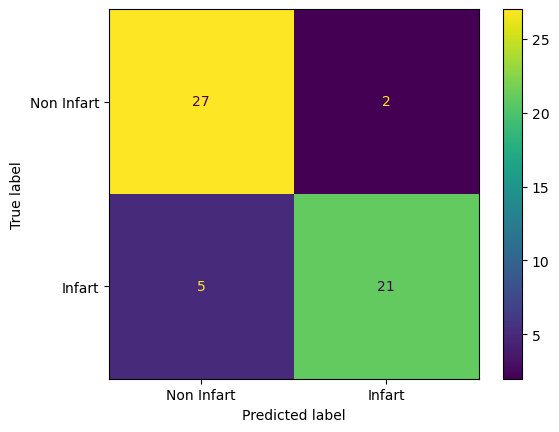

Number of samples: 55
Specificity= 0.8275862068965517
Sensibility= 0.8846153846153846




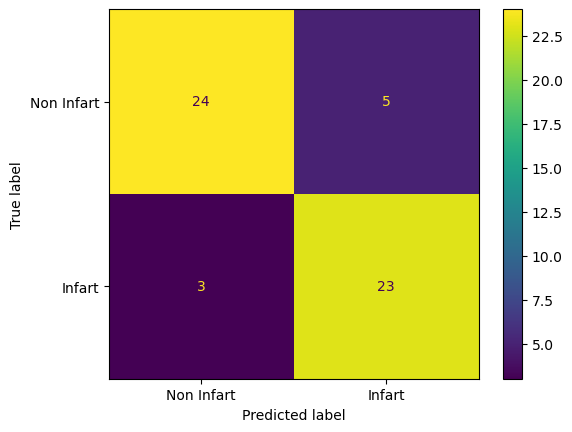

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.7692307692307693




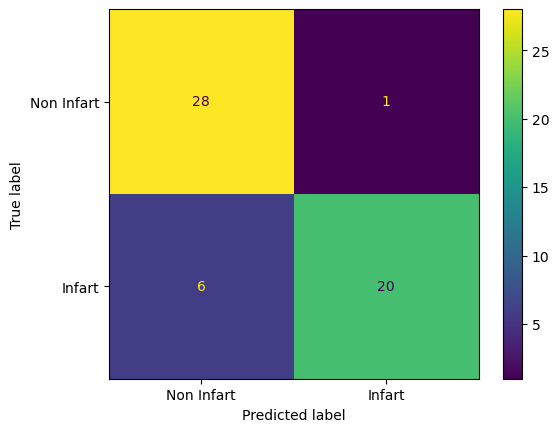

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.7692307692307693




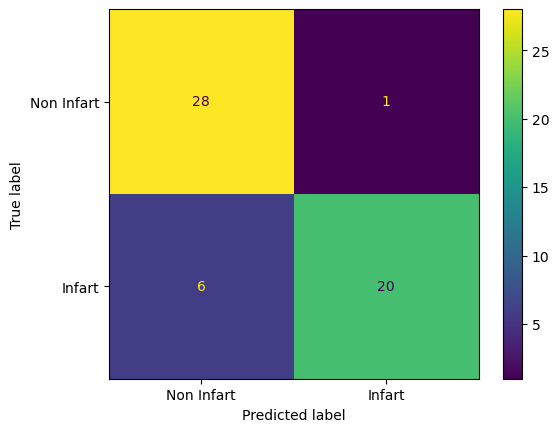

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077




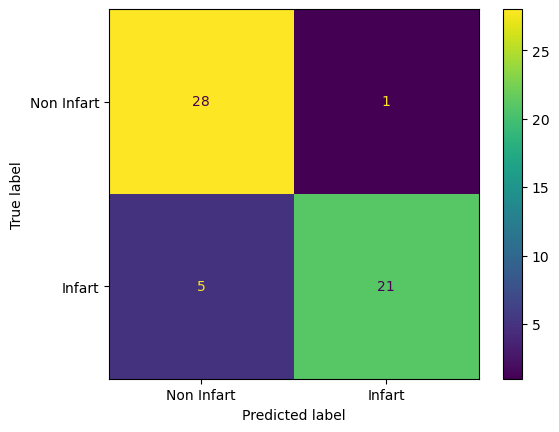

Mean Specificity= 0.9310344827586207 Std: 0.05342045994768853
Mean Sensibility= 0.8076923076923077  Std: 0.042132504423474285


In [33]:
model = SVC()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_total=X_train, y_total=y.values)